# Goal 

The goal of this notebook is to predict the houses prices and figure out what is the best model to do that. 

Most of the functions used in this notebook are in the *daftmodel.py* module.

# Data

## Import Libraries and Set Options

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (train_test_split, cross_validate, GridSearchCV, 
                                     ParameterGrid, cross_val_score)
from sklearn.preprocessing import (StandardScaler, OneHotEncoder,
                                   PolynomialFeatures, PowerTransformer)
from sklearn.impute import SimpleImputer

from daftpy.daftfeanalysis import missing_values

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error, r2_score

from daftpy.daftmodel import (split_data, scores_statistics, metrics_regression, 
                              plot_learning_curves, compare_models, residuals, 
                              transformer_estimator, IdentityTransformer, get_weights, plot_metrics,
                              get_base_predictions, comp_met)

from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## Load Data

In [3]:
data = pd.read_csv('data/selected_data.csv', sep=',')
data.shape 

(7344, 9)

-------------

**Clusters** (Fail)

As indicated in the notebook *Clustering_Real_Estate_Data* the data below have been used to try to improve the performance of the algorithms. However, the results were a little bit worse so it has been quited (raw cells). The mean absolute errors with the cluster variable are shown at the end of the notebook, just for comparation.

-------------

**Predictors**

Below you can see the predictors that I will use.

In [4]:
# Numeric features
num_features = list(data.select_dtypes('number').columns) #X_train
num_features.remove('price')
# num_features.remove('longitude')
# num_features.remove('latitude')

# Categorical features
cat_features =  list(data.select_dtypes('object').columns)
cat_features.remove('city_district')

# Make DataFrames to present the features
num_feat_df = pd.DataFrame({'numerical': num_features}) 
cat_feat_df = pd.DataFrame({'categorical': cat_features})

# Merge both DataFrames
feat_df = num_feat_df.merge(cat_feat_df, how='left', left_index=True, right_index=True).fillna(' ')
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


**Categorical Predictors Levels**

In [5]:
# Add `Unknown` to give it to missing values and not have an error  with levels
levels_type_house = list(data.type_house.unique())
levels_type_house.append('Unknown')
levels_type_house.remove(np.nan)
#levels_type_house = np.append(levels_type_house, 'Unknown')
levels_place = list(data.place.unique())
levels_place.append('Unknown')
levels_place.remove(np.nan)
# print(levels_place.shape)
# levels_city_district = data.city_district.unique()

cat_feat_df['n_levels'] = [len(levels_place), len(levels_type_house)] #, levels_city_district
cat_feat_df['sample'] = [levels_place[:5], levels_type_house] #, levels_city_district[:4]
cat_feat_df # mejorar

,categorical,n_levels,sample
0,place,137,"[Naas, Wexford, Dublin 8, Dublin 6W, Carrick o..."
1,type_house,3,"[house, apartment, Unknown]"


**Missing Values**

In [6]:
missing_values(data)

,Absolute,Relative
price,0,0.000000
floor_area,0,0.000000
bedroom,0,0.000000
bathroom,0,0.000000
place,1208,0.164488
type_house,471,0.064134
longitude,0,0.000000
latitude,0,0.000000
city_district,355,0.048339


There is no missing values in the numeric data.

## Split Data

In [7]:
features = [
    'price',
    'floor_area',
    'latitude',
    'longitude',
    'bedroom',
    'bathroom',
    'type_house',
#    'city_district',
    'place',
#    'cluster'
]

data = data[features].copy()
data.shape

(7344, 8)

In [8]:
# Mean prices to build the Baseline Model
# It is needed to calculate it before splitting the data
mean_prices = data.groupby('place')[['price','place']].mean().sort_values('price', ascending=False)

mean_prices.head(3)

,price
place,
Dublin 6,1.047290e+06
Dun Laoghaire,8.952080e+05
Dublin 4,8.143643e+05


-------------

**Drop Missing Values** (Fail)

Dropping missing values ends in a significant lost of performance. Because of that, the missing values will be handle in another way. The metrics having dropped the missing values are at the end of the notebook.

-------------

The `split_data()` function lets us splitting the data in several ways if I wish.

In [9]:
X_train, X_test, y_train, y_test = split_data(data=data, 
                                              target='price', 
                                              test_size=.15, 
                                              output='X_y_train_test',
                                              random_state=7)

X_train: (6242, 7) 
X_test: (1102, 7) 
y_train: (6242,) 
y_test: (1102,) 



# Metrics

I will use the following metrics to evaluate the models:

In [10]:
# It will be used in the `scores_statistics()` function
scoring = {'r2': 'r2', 
           'MAE': 'neg_mean_absolute_error', 
           'MAPE': 'neg_mean_absolute_percentage_error', 
           'RMSE': 'neg_root_mean_squared_error'}

# Missing Values Treatment And Transformations

The missing values are handle through the `transformer_estimator()` function. Below you can see the performance for the best model according to different combinations of missing values traetment. 

As there is no missing values in the numeric data it is not possible to the improve the performance by modifying the *SimpleImputer()* for numeric data. But it is possible to modify it for categorical data since the `place` and `type_house` features have missing values.

Voting Regressor 2 MAE:
- Fill with `None` strategy: 68,951€
- Fill with `most_frequent` strategy: 69,020€

Selected Strategy:
- Numeric data: Nothing, there is no missing values.
- Categorical data: fill with `Unknown`

**Transformations**
- Numeric Data: 
    - Multiple Linear Regression: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
    - Polynomial Regression: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
    - K-Nearest Neighbors Regressor: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
    - Decision Tree Regressor: Identity
        - Predictors: Nothing, Identity
        - Target: Logarithmic
    - Voting Regressor BA: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
    - Random Forest Regressor: 
        - Predictors: Nothing, Identity
        - Target: Logarithmic
    - Extreme Gradient Boosting: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
    - Voting Regressor with Ensemble Methods: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
    - Stacking: 
        - Predictors: Yeo-Johnson
        - Target: Logarithmic
- Categorical Data:
    - One Hot Encoding

# Models

## Baseline Model

The baseline model consist in taking the mean price in the corresponding place as the prediction price for a house. If there are missing values in the `place` column it will be missing values in the predictions so the `get_base_predictions()` function will fill them with the mean price for Ireland.

I will use this model's performance to compare with the other ones.

In [11]:
print('Performance on the training set:\n', '-'*10)
y_pred_train = get_base_predictions(mean_prices=mean_prices, data_to_predict=X_train)
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

metrics_to_plot = {}
print('Performance on the test set:\n', '-'*10)
y_pred = get_base_predictions(mean_prices=mean_prices, data_to_predict=X_test)
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

# Add metrics to the dictionary to plot it 
metrics_to_plot['Baseline Model'] = metrics

Performance on the training set:
 ----------
R²: 0.3366146919030736
MAE: 157537.5281846715
MAPE: 0.5009050686059635
RMSE: 247639.9117981296
R (corr): 0.581197357024071

Performance on the test set:
 ----------
R²: 0.23766197391151822
MAE: 149689.27015807052
MAPE: 0.5023062442705521
RMSE: 222662.44453701816
R (corr): 0.5102568176397978



### Metrics

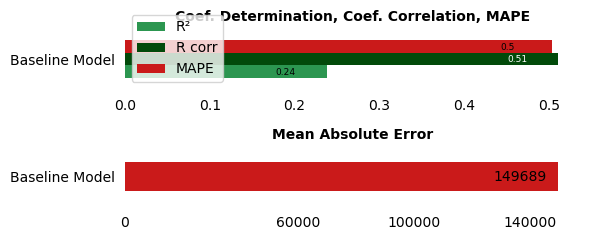

In [12]:
plot_metrics(metrics_to_plot)

## Multiple Linear Regression

I will use the `transformer_estimator()` function to encoder categorical variables, transform numerical variables and fill with `Unknown` categorical ones with missing values.

Then I will use the `scores_statistics()` function to plot the metrics after doing cross validation. If we apply a logarithmic transformation to the target variable when using the `scores_statistics()` function the MAE, MAPE, and RMSE metrics won't be very useful for us since the antilogarithmic transformation won't be made to the target variable before calculating the metrics. Due to that when using the `socores_statistics()` the main metric will be the coefficient of determination R². Bellow in the overfitting analysis we can use all the metrics as the antilogarithmic transformation was made before calculating them.

In [13]:
lr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                          levels_list=[levels_place, 
                                                       levels_type_house],
                                          regressor=LinearRegression(), 
                                          poly_degree=1, 
                                          num_feat=num_features,
                                          cat_feat=cat_features)

scores_lr, scores_resume_lr = scores_statistics(estimator=lr_pipe_estimator, 
                                                scoring_dict=scoring, 
                                                X_train=X_train, 
                                                y_train=np.log(y_train), # Logarithmic Transformation
                                                cv=5, 
                                                return_train_score=False)

r2 mean: 0.7654734105123062
r2 std: 0.008793168092988642 

MAE mean: -0.21658305135659112
MAE std: 0.0032906656604913148 

MAPE mean: -0.01718153959913684
MAPE std: 0.00027491362443028184 

RMSE mean: -0.29494027306775256
RMSE std: 0.005549458005306125 



Above you can see the resulting metrics using cross validation. 

### Overfitting Analysis

Now I will check whether there is overfitting or not by calculating the metrics for the train and test sets. I will use the `metrics_regression()` function to do that.

In [14]:
# Logarithmic transformation to the `price` column
#y_train_log = np.log(y_train)
# Fit estimator
lr = lr_pipe_estimator.fit(X_train, np.log(y_train))  # Logarithmic Transformation

print('Performance on the training set:\n', '-'*10)
# Antilogarithmic transformation to the predicted prices to compare it with the actual price
# The actual prices are still without any transformation so the antilogarithmic transformation
# is nedeed
y_pred_train = np.exp(lr.predict(X_train))

metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, #y_pred_train_antilog
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(lr.predict(X_test))

metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, #y_pred_antilog
                             squared=False)

metrics_to_plot['Linear Regression'] = metrics

Performance on the training set:
 ----------
R²: 0.7659647508580196
MAE: 82250.51744762078
MAPE: 0.2191421480412837
RMSE: 147088.37597180324
R (corr): 0.8849119426355939

Performance on the test set:
 ----------
R²: 0.7403753142532407
MAE: 77092.01996534776
MAPE: 0.22201867429977062
RMSE: 129940.99052481589
R (corr): 0.8624247706772742



Mean Absolute Error in the train set is only 5,000€ greater than in the test set so we can consider that there is not overfitting.

**Intercept**

In [15]:
# lr.steps[1][1].intercept_

**Coeficients**

In [16]:
# lr.steps[1][1].coef_

### Residuals Diagnostic

The `residuals()` function plots the actual values against the predicted ones in addition to the residuals. This will help us to understand how the model is working.

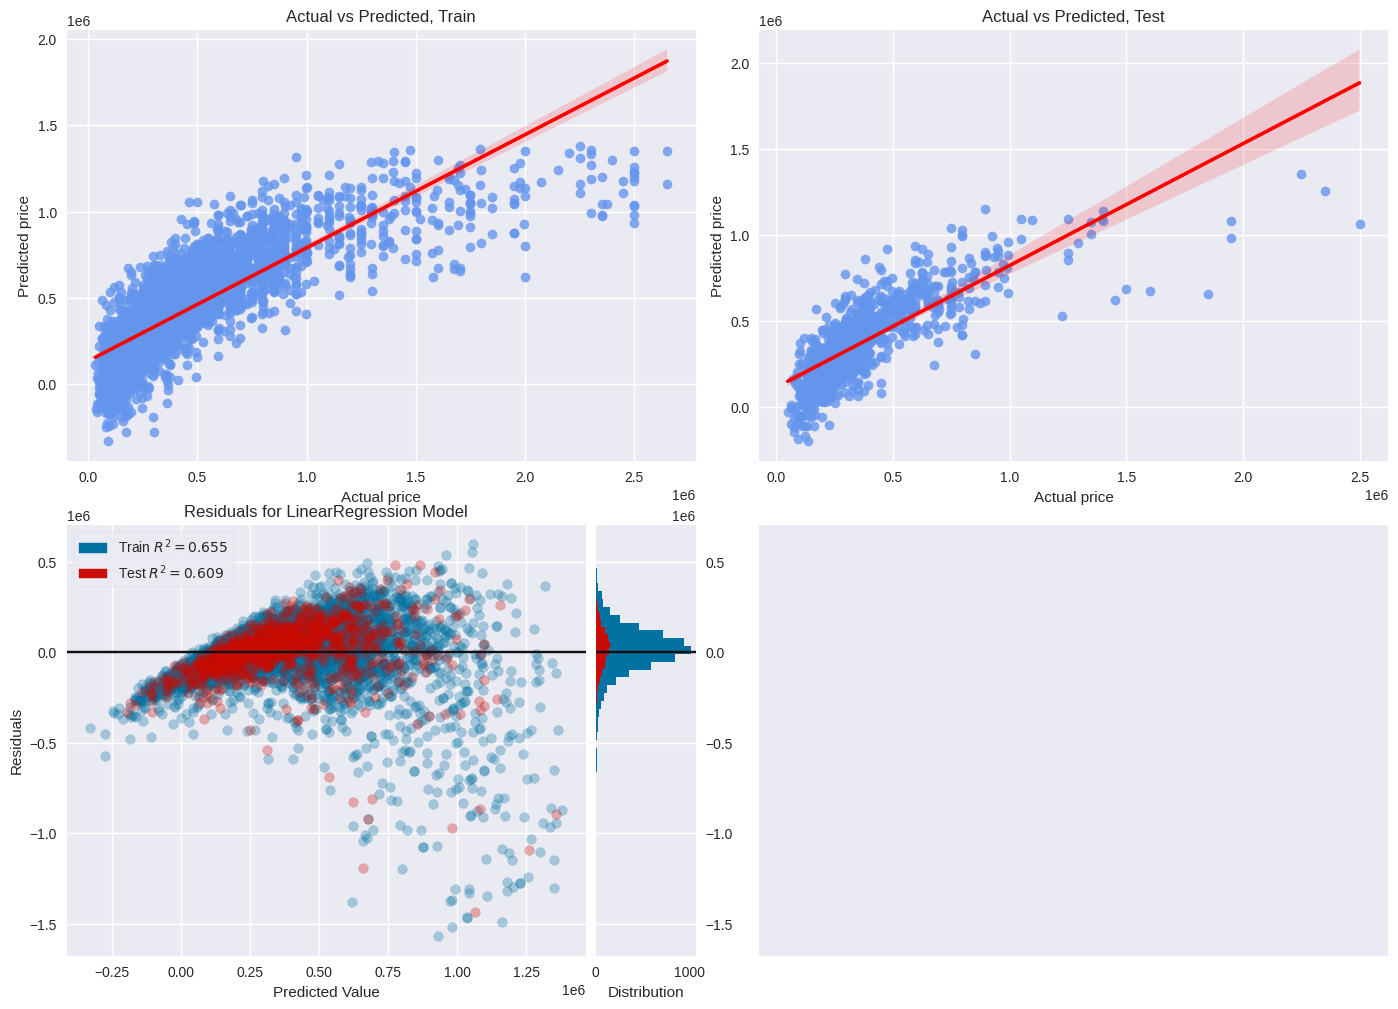

In [17]:
residuals(lr_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**

The residuals are calculated substracting the actual value from the predicted one: **residuals = y_pred_train - y_train** 
This means that if the predicted value is greater than the actual one the addition will be positive.

- The model predices a few negative values, which is not possible in the real world.
- The model doesn't predice well the price of expensive houses. When a house is very expensive the model tends to understimate it.
- We can consider that there is no overfitting.

### Metrics

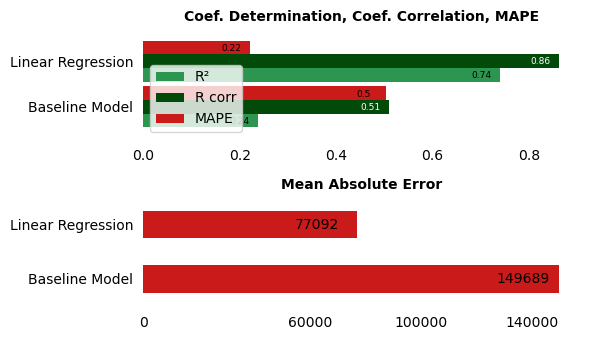

In [18]:
plot_metrics(metrics_to_plot)

A simple linear regression model improve the metrics a lot. Now the MAE is 72,000€ lower!

In [19]:
comp_met(metrics_to_plot, 'Linear Regression', 'Baseline Model')

Improvement respect Baseline Model: 72597€ -> 48%
Improvement respect Last Best Model: 72597€ -> 48%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|72,597€||
|48%||

## Polynomial Regression

First I will instance the `GridSearchCV` class and fit it to the training set to figure out the best hyperparameters. In this case I will try only different degrees to see what polinomial regression is the best.

In [20]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_place, levels_type_house],
                                            regressor=LinearRegression(), 
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

grid_search = GridSearchCV(estimator=poly_pipe_estimator, 
                           param_grid={'preprocessor__num__poly__degree': range(1, 8)}, 
                           cv=5, 
                           n_jobs=-1)
# I apply a log transformation to the target
grid_search.fit(X_train, np.log(y_train))

print(grid_search.best_params_)
print(grid_search.best_score_)
# grid_search.best_estimator_

{'preprocessor__num__poly__degree': 4}
0.7928184790851966


Once I have the best degree I use it to get an estimator and as a parameter to the function `scores_statistics()`, as I did earlier. 

In [21]:
poly_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            levels_list=[levels_place, levels_type_house],
                                            regressor=LinearRegression(),
                                            poly_degree=4,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=poly_pipe_estimator, 
                                          scoring_dict=scoring, 
                                          X_train=X_train, 
                                          y_train=np.log(y_train), # Log transformation applied
                                          cv=5, 
                                          return_train_score=False)

r2 mean: 0.7928184790851968
r2 std: 0.004485690289961673 

MAE mean: -0.2038427354598086
MAE std: 0.001810217533467911 

MAPE mean: -0.016177421064510096
MAPE std: 0.00015462024412915155 

RMSE mean: -0.2772430677820343
RMSE std: 0.0026653022796503207 



### Overfitting Analysis

In [22]:
# Apply logarithmic transformation to the target variable
poly = poly_pipe_estimator.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
# Apply antilogarithmic transformation to the prediction obtained
y_pred_train = np.exp(poly.predict(X_train))
metrics_regression(y_test=y_train, 
                    y_pred=y_pred_train, 
                    squared=False)

print('Performance on the test set:\n', '-'*10)
# Apply antilogarithmic transformation to the prediction obtained
y_pred = np.exp(poly.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Polynomial Regression'] = metrics

Performance on the training set:
 ----------
R²: 0.8286256016493777
MAE: 74279.53732545768
MAPE: 0.1980574551617582
RMSE: 125866.65414406535
R (corr): 0.9126604229438949

Performance on the test set:
 ----------
R²: 0.7877040579998882
MAE: 70216.08962823731
MAPE: 0.2019084158446506
RMSE: 117501.66685748476
R (corr): 0.8887495843814354



The difference in MAE is only 5,000€ so I can consider that there is not overfitting.

**Intercept**

In [112]:
# poly.steps[1][1].intercept_

**Coeficients**

In [111]:
# lr.steps[1][1].coef_

### Residuals Diagnostic

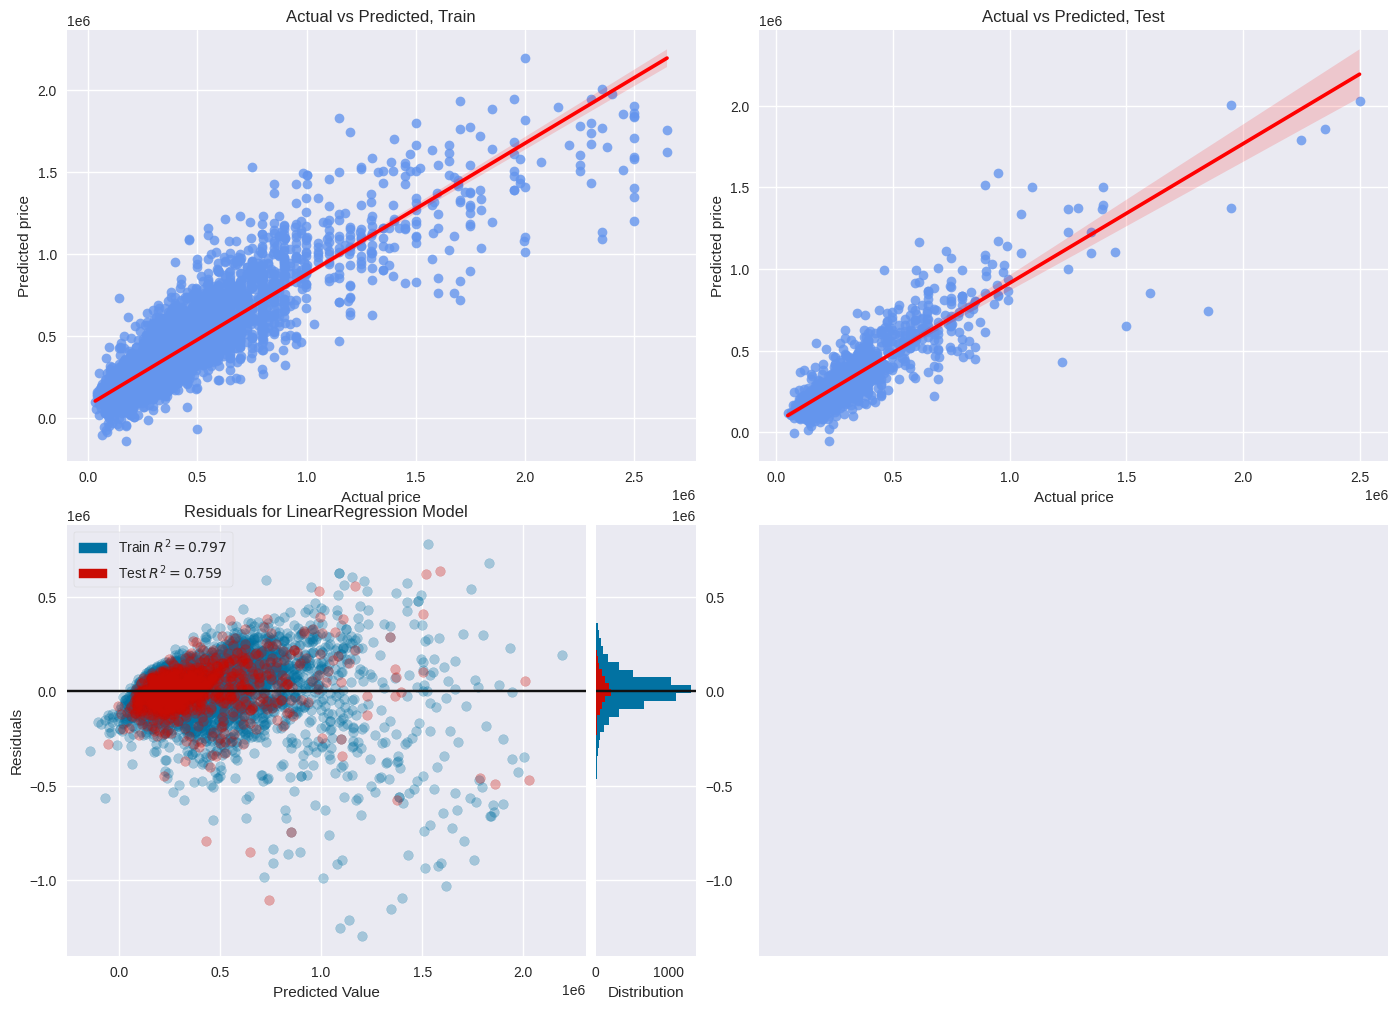

In [23]:
residuals(poly_pipe_estimator, X_train, X_test, y_train, y_test) 

**Conclusions**

- The model still predices a few negative values.
- The model doesn't predice well the price of expensive houses. It also tends to understimate the value of expensive houses but is better than the linear regression.
- We can consider that there is not overfitting.

### Metrics

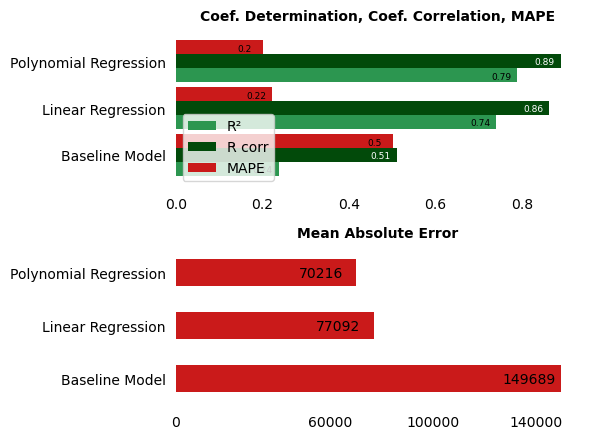

In [24]:
plot_metrics(metrics_to_plot)

The polynomial regression with degree four is even better than the linear regression. 

In [25]:
comp_met(metrics_to_plot, 'Polynomial Regression', 'Linear Regression')

Improvement respect Baseline Model: 79473€ -> 53%
Improvement respect Last Best Model: 6876€ -> 9%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|79,473€|6,876€|
|53%|9%|

## K-Nearest Neighbors Regressor

When apply the K-Nearest Neighbors Regressor the prediction is made based on the mean of its nearest neighbors. Bellow I use a `GridSearchCV` to find the best hyperparameters. 

In [26]:
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(),
                                            levels_list=[levels_place, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

param_grid = [{
        'preprocessor__num__poly__degree': [1,3,4],
        'regressor__n_neighbors': [7],  
        'regressor__weights': ['uniform', 'distance'],
        'regressor__leaf_size': [30]
             }]

grid_search = GridSearchCV(estimator=knnr_pipe_estimator, 
                           param_grid=param_grid,
                           cv=3, 
                           n_jobs=-1)

grid_search.fit(X_train, np.log(y_train))

print(grid_search.best_params_)
print(grid_search.best_score_)

{'preprocessor__num__poly__degree': 1, 'regressor__leaf_size': 30, 'regressor__n_neighbors': 7, 'regressor__weights': 'distance'}
0.7585042377133773


In [27]:
# I use weights = 'uniform' instead of 'distance' to reduce overfitting
knnr_pipe_estimator = transformer_estimator(num_transformation='power_transformer', 
                                            regressor=KNeighborsRegressor(n_neighbors=7,
                                                                          weights='uniform', 
                                                                          leaf_size= 30), 
                                            levels_list=[levels_place, levels_type_house],
                                            poly_degree=1,
                                            num_feat=num_features,
                                            cat_feat=cat_features)

scores, scores_resume = scores_statistics(estimator=knnr_pipe_estimator, 
                                          scoring_dict=scoring, 
                                          X_train=X_train, 
                                          y_train=np.log(y_train), 
                                          cv=5, 
                                          return_train_score=False, 
                                          return_est=True)

r2 mean: 0.7501054675759022
r2 std: 0.005642470260061562 

MAE mean: -0.22394691459807353
MAE std: 0.0037500228801364173 

MAPE mean: -0.01773907306995261
MAPE std: 0.00031249531660800374 

RMSE mean: -0.304521008806112
RMSE std: 0.0058383329071859495 



### Overfitting Analysis

In [28]:
knnr = knnr_pipe_estimator.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(knnr.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(knnr.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['K-Nearest Neighbors'] = metrics

Performance on the training set:
 ----------
R²: 0.8023825246443257
MAE: 75132.63366265739
MAPE: 0.19433133088946827
RMSE: 135160.68666945765
R (corr): 0.8998340915730323

Performance on the test set:
 ----------
R²: 0.7338697034296486
MAE: 77801.56523415334
MAPE: 0.21543902200257609
RMSE: 131558.9322556686
R (corr): 0.8588097812813003



The difference between performance in the training set is similar to the test set, it is a MAE of 3,000€ so it is okay in my opinion.

### Residuals Diagnostic

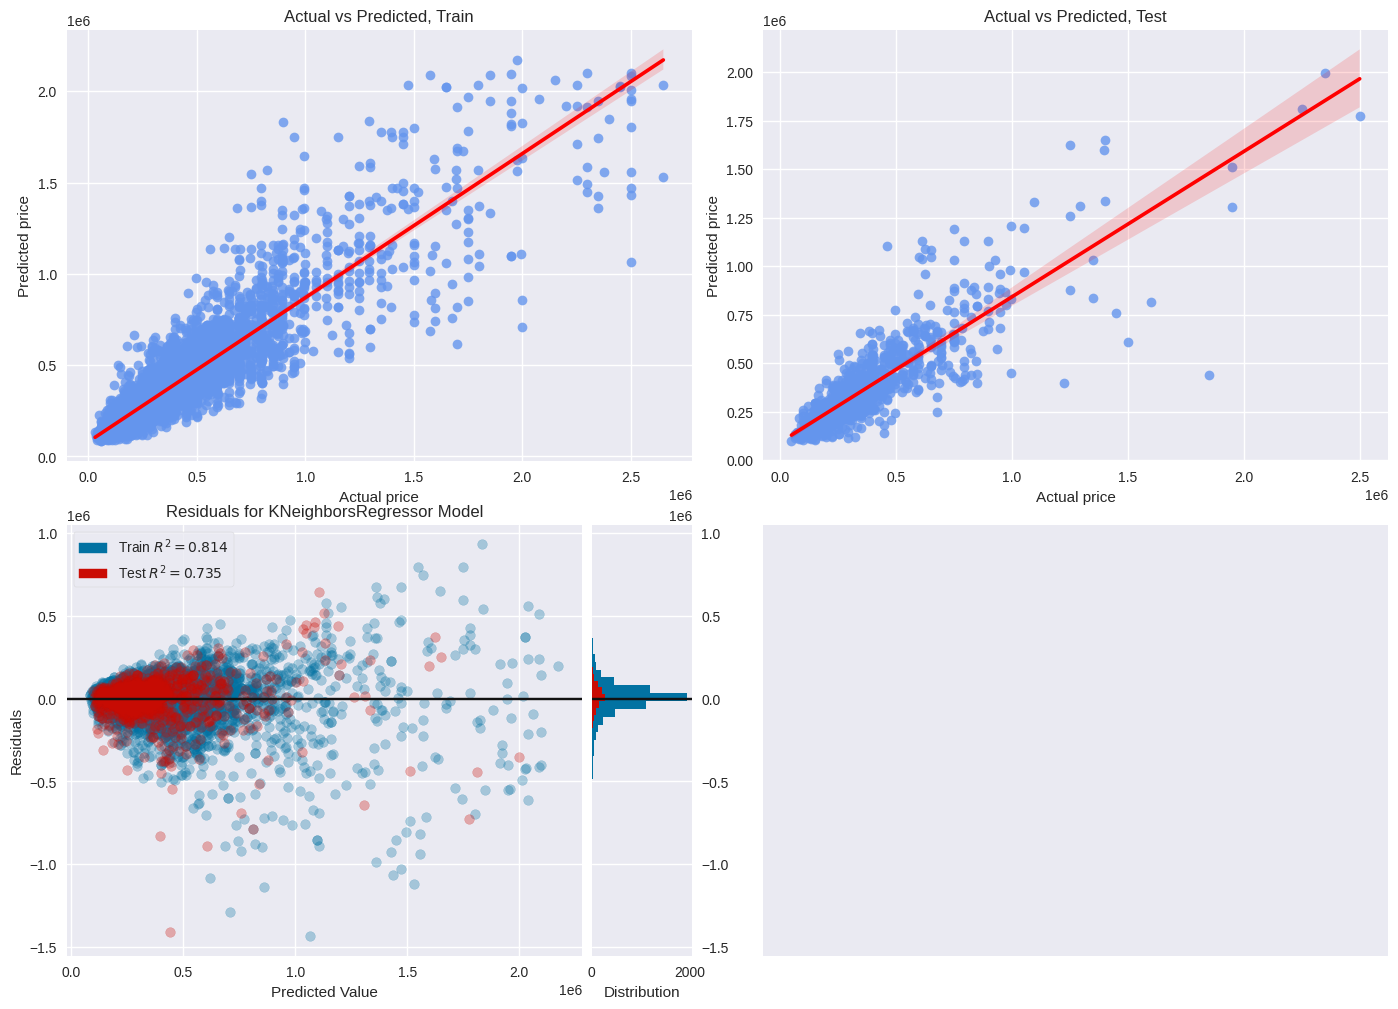

In [29]:
residuals(knnr_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**

- This time we don't have negative values!
- The model is not very good predicing prices of houses with actual prices above a million, but there is no a so clear tendency to understimate them as in the previous models, but there it is.
- There is no overfitting.

### Metrics

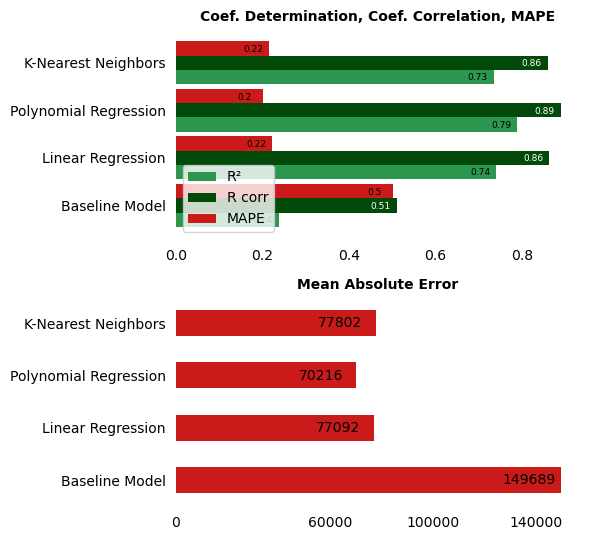

In [30]:
plot_metrics(metrics_to_plot)

In [31]:
comp_met(metrics_to_plot, 'K-Nearest Neighbors', 'Polynomial Regression')

Improvement respect Baseline Model: 71888€ -> 48%
Improvement respect Last Best Model: -7585€ -> -11%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|71,888€|-7,585€|
|48%|-11%|

## Decision Tree Regressor

In [32]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features)

grid_search = GridSearchCV(estimator=dtr_pipe_estimator, 
                           param_grid={
                               'preprocessor__num__poly__degree': [1,3,4], #[1,2,3,4],
                               'regressor__max_depth': [10,11,12,13,14,15,16,17], #range(5, 15), #[2,3,4,5,6,7]
                               'regressor__min_samples_leaf': [10,11,12,13,14,15, 20, 25, 30], #[1, 3, 5, 10, 20, 50]
                   #            'regressor__min_samples_split': range(35, 45), #[2, 43],
                      #         'regressor__max_leaf_nodes': range(65, 75),
                         #      'regressor__max_features':,
                           }, 
                           cv=5, 
                           n_jobs=-1)

grid_search.fit(X_train, np.log(y_train))
print(grid_search.best_params_)
print(grid_search.best_score_)


{'preprocessor__num__poly__degree': 1, 'regressor__max_depth': 13, 'regressor__min_samples_leaf': 11}
0.7588573219202797


In [33]:
#pd.DataFrame(grid_search.cv_results_)

In [34]:
dtr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=DecisionTreeRegressor(max_depth=10,
                                                                           min_samples_leaf=30,  #16
                                                                        #  min_samples_split=43,
                                                                        #  max_leaf_nodes=68, 
                                                                           random_state=7),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=3, # 3 gave me better performance with these parameters
                                           num_feat=num_features,
                                           cat_feat=cat_features)

scores = scores_statistics(estimator=dtr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=np.log(y_train), 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.72647710201515
r2 std: 0.005337008978796426 

MAE mean: -0.23786048187153952
MAE std: 0.002194314817542958 

MAPE mean: -0.01884657502727642
MAPE std: 0.00014928285672148356 

RMSE mean: -0.3186028698584672
RMSE std: 0.006050555650220516 



In [35]:
# dtr_pipe_estimator

### Overfitting Analysis

In [36]:
dtr = dtr_pipe_estimator.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(dtr.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(dtr.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Decision Tree Regressor'] = metrics

Performance on the training set:
 ----------
R²: 0.7897428789656684
MAE: 79672.52852966254
MAPE: 0.21242493002120078
RMSE: 139416.14596835256
R (corr): 0.8906520946609725

Performance on the test set:
 ----------
R²: 0.7146269912881522
MAE: 81283.39089374401
MAPE: 0.2318751798429888
RMSE: 136232.15547659152
R (corr): 0.8525189625440474



In [37]:
# dtr

The different in MAE is insignificant so there is no overfitting. I have changed the parameter values to regularize a little the model as the different in the metrics was bigger earlier. That is why the parameters are different that the GridSearchCV ones.

In [38]:
# dtr.steps[1][1].feature_importances_

### Residuals Diagnostic

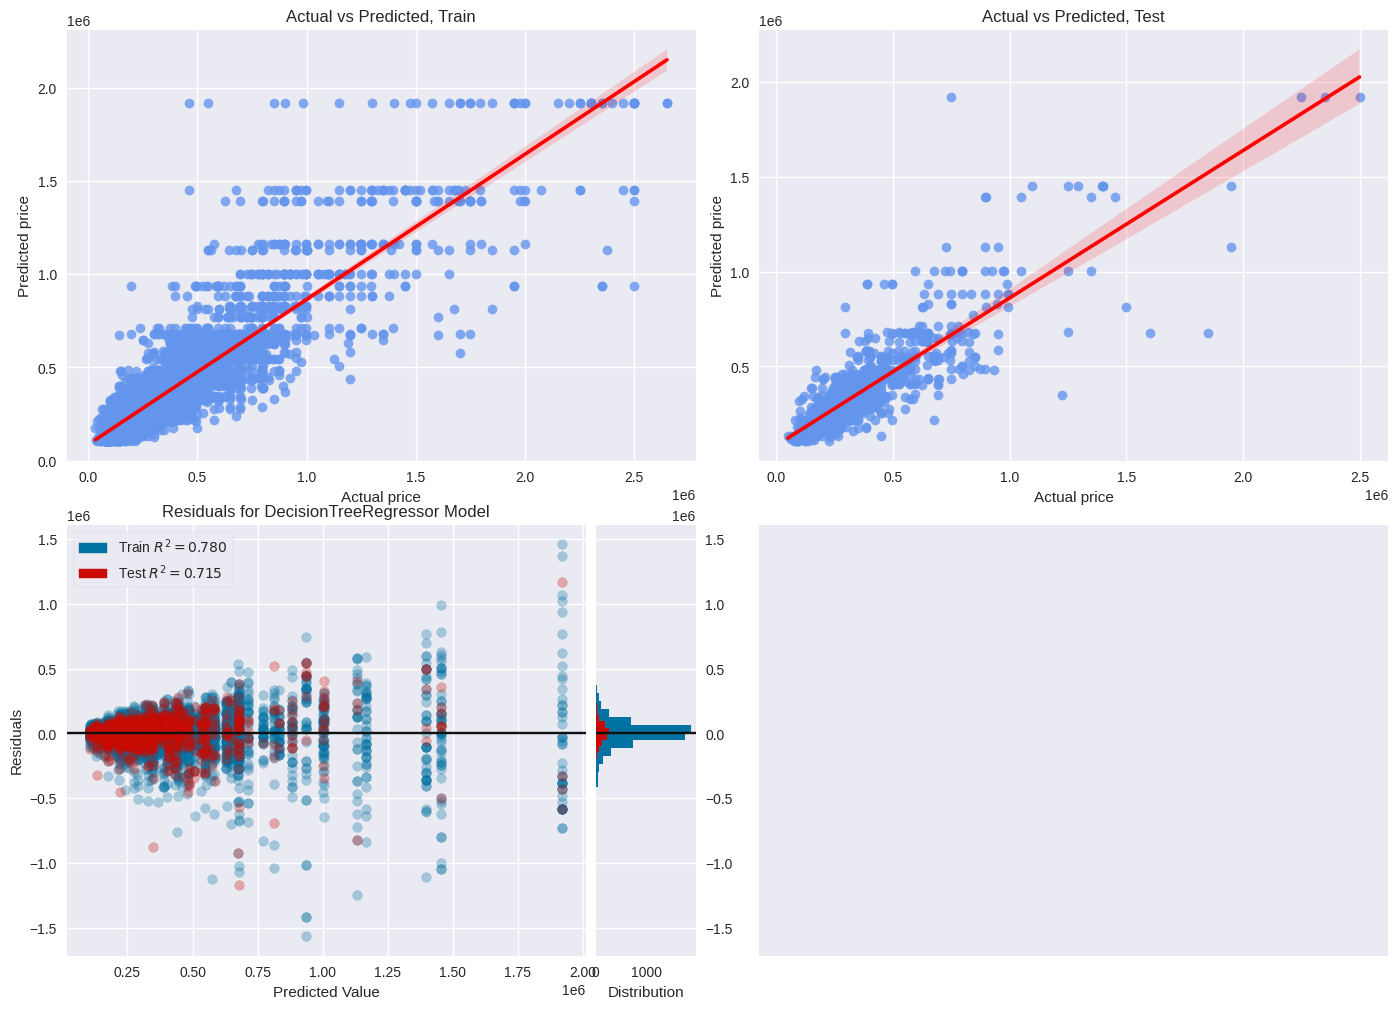

In [39]:
residuals(dtr_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**
- The model appears to be pretty accurate in values less than 1 million € but the errors increase a lot as the actual price increases as well.
- There is a tendency to understimate values and it is clearer in houses with high values. However, some values with very high actual prices are overstimated as can be observed in the first and third graphs. They can be seen in the horizontal lines in the first graph or in the vertical ones in the thikrd graph. Overstimated values are very dangerous for us, more than the understimated values because overstimated values could encourage us to invest money being the actual value of the asset lower.
- There is no overfitting.

### Metrics

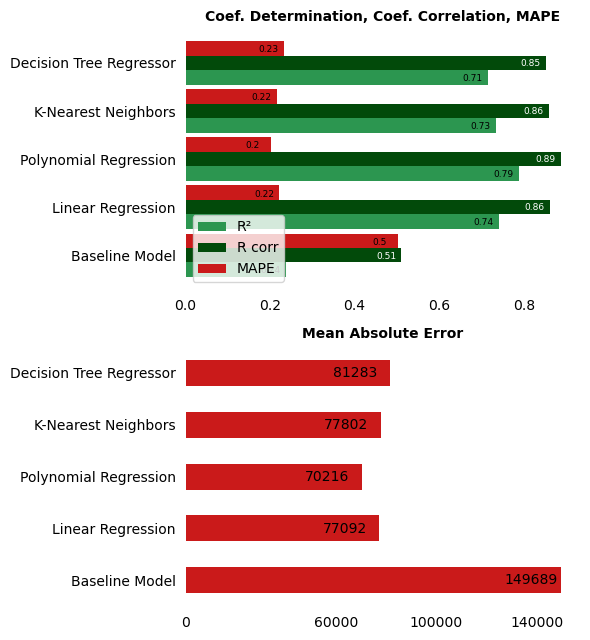

In [40]:
plot_metrics(metrics_to_plot)

In [41]:
comp_met(metrics_to_plot, 'Decision Tree Regressor', 'Polynomial Regression')

Improvement respect Baseline Model: 68406€ -> 46%
Improvement respect Last Best Model: -11067€ -> -16%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|68,406€|-11,067€|
|46%|-16%|

## Voting Regressor with Basic Algorithms

I think it is interesting to investigate how the basic algorithms we used above can perform together. So let's do a voting regresor with them to figure out that. This voting regressor is provided by three learners:
- Polynomial Regression
- K-Nearest Neighbors Regressor
- Decision Tree Regressor

Hopefully they are enough diverse to achieve a higher score together than each one separately.

In [42]:
scoring_comp = {'r2': 'r2',
                'MAE': 'neg_mean_absolute_error'}

Calculate the weights:

The weigths will be proportional to their scores in the test set.

In [43]:
scores_dict = {}
scores_dict['Polynomial Regression'] = metrics_to_plot['Polynomial Regression'][0]
scores_dict['K-Nearest Neighbors'] = metrics_to_plot['K-Nearest Neighbors'][0]
scores_dict['Decision Tree Regressor'] = metrics_to_plot['Decision Tree Regressor'][0]


models_weigth_list = get_weights(scores_dict=scores_dict)

{'Polynomial Regression': 0.7877040579998882, 'K-Nearest Neighbors': 0.7338697034296486, 'Decision Tree Regressor': 0.7146269912881522}


In [44]:
# Learners to provide
polyr = poly_pipe_estimator
knnr = knnr_pipe_estimator
dtr = dtr_pipe_estimator

voting_regressor_BA = VotingRegressor(
    estimators = [('poly', polyr),
                  ('knn', knnr),
                  ('dt', dtr)], 
    weights = models_weigth_list)

models_dict = {'Polynomial Regression': poly_pipe_estimator, 
               'K Nearest Neighbors Regressor': knnr_pipe_estimator, 
               'Decission Tree Regressor': dtr_pipe_estimator, 
               'Voting Regressor': voting_regressor_BA}
# Comparing with corss validation
for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring, 
                            X_train=X_train, 
                            y_train=np.log(y_train), # Log tranformation
                            cv=5, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7928184790851968
MAE mean: -0.2038427354598086
MAPE mean: -0.016177421064510096
RMSE mean: -0.2772430677820343
----------
K Nearest Neighbors Regressor
r2 mean: 0.7501054675759022
MAE mean: -0.22394691459807353
MAPE mean: -0.01773907306995261
RMSE mean: -0.304521008806112
----------
Decission Tree Regressor
r2 mean: 0.72647710201515
MAE mean: -0.23786048187153952
MAPE mean: -0.01884657502727642
RMSE mean: -0.3186028698584672
----------
Voting Regressor
r2 mean: 0.7975002586096303
MAE mean: -0.20011488206715738
MAPE mean: -0.015874174320430874
RMSE mean: -0.2741493421917168
----------


Cool! We have been able to improve the performance with the voting regressor. It is not too much but it can be appreciate better in the MAE, as shown bellow in the graph of the metrics.

Next we will do the overfitting analysis and the residuals diagnostic before start making more complex models. 

### Overfitting Analysis

In [45]:
# Apply logarithmic transformation to the target variable
voting_regressor_BA.fit(X_train, np.log(y_train))

# Apply antilogarithmic transformation to the prediction obtained
print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(voting_regressor_BA.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

# Apply antilogarithmic transformation to the prediction obtained
print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(voting_regressor_BA.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Voting Regressor BA'] = metrics

Performance on the training set:
 ----------
R²: 0.8347791481637936
MAE: 69011.47943758665
MAPE: 0.1817281467027921
RMSE: 123586.24716961366
R (corr): 0.9201779468729389

Performance on the test set:
 ----------
R²: 0.7904928639240477
MAE: 68100.77981380335
MAPE: 0.19463782290713355
RMSE: 116727.3406180426
R (corr): 0.8900057544827527



The different in MAE is less than 1,000€ so we will consider there is no overfitting.

### Residuals Diagnostic

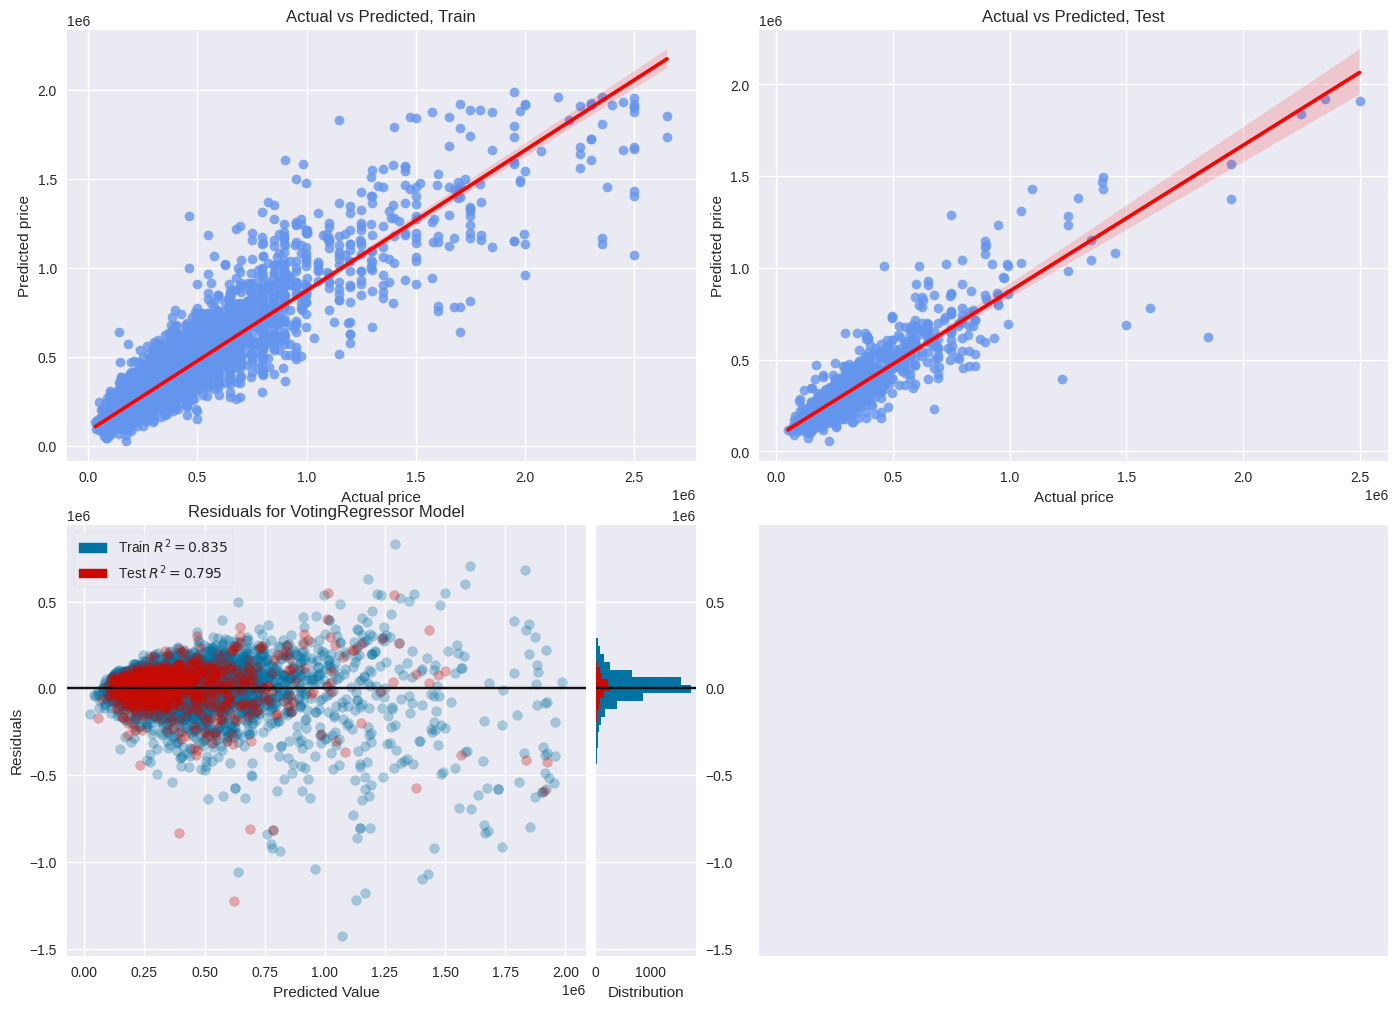

In [46]:
residuals(voting_regressor_BA, X_train, X_test, y_train, y_test)

**Conclusions**
- The voting regressor is a little bit better than the models separately.  
- Once again we can realise that houses which actual price is higher than 1 million € are generally worst predicted than the other ones.
- There is a clear tendency to understimate prices as the actual prices increase. This is normal as the models that make up the voting regressor suffer the same condition.

### Metrics

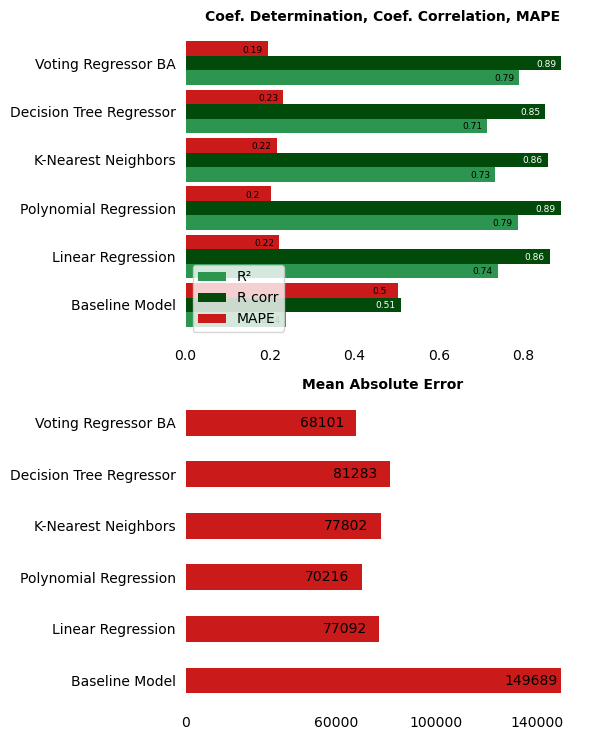

In [47]:
plot_metrics(metrics_to_plot)

In [48]:
comp_met(metrics_to_plot, 'Voting Regressor BA', 'Polynomial Regression')

Improvement respect Baseline Model: 81588€ -> 55%
Improvement respect Last Best Model: 2115€ -> 3%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|81,588€|2,115€|
|55%|3%|

## Random Forest Regressor

The random forest regressor cells have been runned iteratively several times in order to find the best combination of hyperparameters that maximize the performance while overfitting is under control.

I use the *Out-of-Bag scores* to evaluate the random forests and finding the optimal number of estimators. The graph bellow shows the evolution of the Coefficient of Determination as the number of estimators increases.

/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,
/home/javier/anaconda3/envs/tfm/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:554: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  UserWarning,


Optimal number of estimators: 41


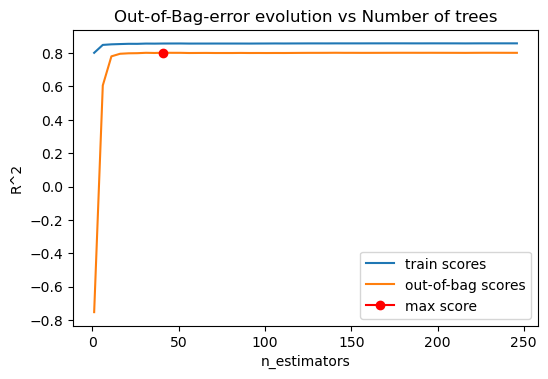

In [49]:
# Validation using Out-of-Bag error
train_scores = []
oob_scores   = []

# Values evaluated
estimator_range = range(1, 250, 5)

# Loop to train a model with each value of n_estimators and get its training 
# and Out-of-Bag errors
for n_estimators in estimator_range:
    rfr = transformer_estimator(num_transformation='identity', 
                                regressor=RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=10,
                                    min_samples_leaf=9,  
                                    random_state=7,
                                    bootstrap=True,
                                    n_jobs=-1,
                                    oob_score = True), 
                                levels_list=[levels_place, levels_type_house],
                                poly_degree=1,
                                num_feat=num_features,
                                cat_feat=cat_features)

    
    rfr.fit(X_train, y_train)
    train_scores.append(rfr.score(X_train, y_train))
    oob_scores.append(rfr.steps[-1][1].oob_score_)
    
# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Out-of-Bag-error evolution vs Number of trees")
plt.legend();
print(f"Optimal number of estimators: {estimator_range[np.argmax(oob_scores)]}")

After finding out the optimal number of estimators I use `ParameterGrid` to figure out the best combination of hyperparameters. 

In [50]:
# Grid of hyperparameters evaluated
param_grid = ParameterGrid(
                {
                    'n_estimators': [41, 60, 100],
             #       'max_features': range(2, 20, 2), # ['log2', 'sqrt'],
                    'max_depth'   : [None, 3, 10, 20],
             #       'min_samples_split': [2, 5, 8, 15, 20, 43],  # 43
                    'min_samples_leaf': [1, 3, 5, 10, 20, 50],   #16
             #       'max_leaf_nodes': [2, 4, 8, 13, 20, 30, 40, 60, 80],   #68
                })

# Loop to fit a model with each hyperparameters combination
resultados = {'params': [], 'oob_r2': []}

for params in param_grid:   
    modelo = transformer_estimator(num_transformation='identity', 
                                   regressor=RandomForestRegressor(
                               #        n_estimators=41,
                               #        max_depth=10,
                               #        min_samples_leaf=9, 
                                       random_state=7,
                                       bootstrap=True,
                                       n_jobs=-1,
                                       oob_score = True,
                                       **params), 
                                   levels_list=[levels_place, levels_type_house],
                                   poly_degree=1,
                                   num_feat=num_features,
                                   cat_feat=cat_features)
    
    modelo.fit(X_train, y_train)
    
    # print(modelo.steps[-1][1].oob_score_)
    resultados['params'].append(params)
    resultados['oob_r2'].append(modelo.steps[-1][1].oob_score_)
    # print(f"Modelo: {params} \u2713")

# Results
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.drop(columns = 'params')
resultados = resultados.sort_values('oob_r2', ascending=False)
resultados.head(4)

,oob_r2,max_depth,min_samples_leaf,n_estimators
56,0.818203,20.0,1.0,100.0
2,0.817661,NaN,1.0,100.0
59,0.817458,20.0,3.0,100.0
5,0.817411,NaN,3.0,100.0


Despite the results obtained above if we are so little restrictive with the model and we allow it to have too many degrees of freedom the model will overfit the training data. So I have decided to restrict the model throught some hyperparameters in order to avoid it.

In [51]:
rfr = transformer_estimator(num_transformation='identity', 
                            regressor=RandomForestRegressor(
                                n_estimators=41,  
                                max_depth=10,
                                min_samples_leaf=9,  
                                random_state=7,
                                bootstrap=True,
                                n_jobs=-1,
                                oob_score = True), 
                            levels_list=[levels_place, levels_type_house],
                            poly_degree=1,
                            num_feat=num_features,
                            cat_feat=cat_features)
    
rfr.fit(X_train, y_train)
print('Train score:', rfr.score(X_train, y_train))
print('Out-of-bag score', rfr.steps[-1][1].oob_score_)

Train score: 0.8575707805056108
Out-of-bag score 0.8023788760201988


#### Whitout Out-of-Bag Errors

In [52]:
rfr_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=RandomForestRegressor(
                                               n_estimators=180, 
                                               max_depth=10,
                                               min_samples_leaf=9,  
                                               random_state=7,
                                               bootstrap=True,
                                               n_jobs=-1), 
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features)
# As the metric don't change too much I don't use log transf here fot visualization purposes
# In fact the r2 scopre is almost the same
scores = scores_statistics(estimator=rfr_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=y_train, 
                           cv=5, 
                           return_train_score=False)

r2 mean: 0.7948128257083071
r2 std: 0.018037890330472445 

MAE mean: -80470.39412116422
MAE std: 2935.847477489872 

MAPE mean: -0.23063634829650095
MAPE std: 0.007611134757614645 

RMSE mean: -137273.0266374894
RMSE std: 9675.583092940802 



When I tried the bellow model with logarithmic transformation in the target variable and whitout it the results were better with it so I decided leave it with the transformation. The metrics can be compared at the end of the notebook.

In [53]:
rfr = rfr_pipe_estimator.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(rfr.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(rfr.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Random Forest Regressor'] = metrics

Performance on the training set:
 ----------
R²: 0.852958481294227
MAE: 65790.32444361765
MAPE: 0.17705359054905107
RMSE: 116589.03453687142
R (corr): 0.927941421689861

Performance on the test set:
 ----------
R²: 0.7851403274949148
MAE: 69280.55201973698
MAPE: 0.2008810196757365
RMSE: 118209.02515162858
R (corr): 0.8867809849970986



The different between MAE is less than 4,000€ which is okay.

### Feature Importances

The importance of a feature is computed as the (normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance. [Feature_importances scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_)

Now let's investigate a little the feature importances to see if it can be obtained some useful insighs. 

In [54]:
# Number of features importances
len(rfr.steps[1][1].feature_importances_)

145

There are 145 feature importances, which correspond to the 145 features there are after the transformations of the categorical data plus the numerica features.

In [55]:
feat_df

,numerical,categorical
0,floor_area,place
1,bedroom,type_house
2,bathroom,
3,longitude,
4,latitude,


In [56]:
cat_feat_df

,categorical,n_levels,sample
0,place,137,"[Naas, Wexford, Dublin 8, Dublin 6W, Carrick o..."
1,type_house,3,"[house, apartment, Unknown]"


In [57]:
# Numeric features + `place` levels + `type_house` levels
5 + 137 + 3

145

If we wanted to get the features that the random forest was fed with we would need to transform the train set before.

In [58]:
estimator_to_get_features = transformer_estimator(num_transformation='identity',  
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features)

X_train_tr = estimator_to_get_features.fit_transform(X_train)
X_train_tr.shape

(6242, 145)

In [59]:
X_train_tr.toarray()

array([[135.,   3.,   2., ...,   1.,   0.,   0.],
       [ 70.,   2.,   1., ...,   1.,   0.,   0.],
       [182.,   4.,   3., ...,   1.,   0.,   0.],
       ...,
       [ 95.,   3.,   1., ...,   0.,   0.,   1.],
       [ 51.,   2.,   1., ...,   1.,   0.,   0.],
       [ 70.,   2.,   1., ...,   1.,   0.,   0.]])

The above data was given to the algorithm, and if we compare it with the train set bellow we can see that the columns are the same except because above there are 140 columns filled with 0 and 1 instead the tow columns corresponding to `type_house` and `place`.

In [60]:
X_train.head()

,floor_area,latitude,longitude,bedroom,bathroom,type_house,place
5631,135,52.925490,-6.791318,3,2,house,Naas
4768,70,51.861624,-8.252959,2,1,house,Cobh
5862,182,52.626521,-7.218027,4,3,house,Kilkenny
1538,143,51.972982,-8.216473,4,3,house,Fermoy
2368,185,53.699557,-6.260619,4,3,house,Drogheda


It easier to see the importance of the numeric features as they are still in a column. The categorical features are distributed in lots of columns. [feature_importances scikit learn](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor.feature_importances_)

My only idea for now is to add all the scores for the columns corresponding to both categorical columns and see what is the score obtained. As the first five scores belong to the numeric features we can add the rest ones.

In [61]:
sum(rfr.steps[1][1].feature_importances_[5:])

0.018814078638761365

In [62]:
# To confirm that the first 5 columns are the numeric ones
# X_train_tr.toarray()[1]

And finally it would be interisting to plot the numeric features importance scores.

In [63]:
# Numeric columns
X_train.columns[:5]

Index(['floor_area', 'latitude', 'longitude', 'bedroom', 'bathroom'], dtype='object')

In [64]:
# Numeric columns feature importances
rfr.steps[1][1].feature_importances_[:5]

array([0.45573696, 0.00423339, 0.01780583, 0.34117444, 0.1622353 ])

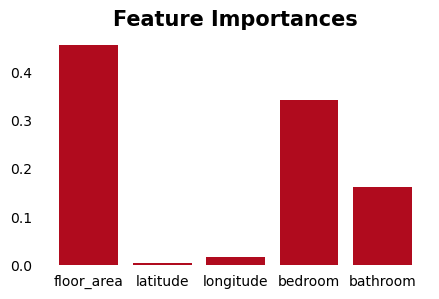

In [65]:
fig, ax = plt.subplots(figsize=(5,3))

plt.bar(X_train.columns[:5], rfr.steps[1][1].feature_importances_[:5], 
            color='#b00b1e')

ax.set_title('Feature Importances', weight='bold', size=15)
ax.tick_params(bottom=False, left=False)
ax.set_xlabel('')
for location in ['left', 'bottom', 'right', 'top']:
    ax.spines[location].set_visible(False)

### Residuals Diagnostic

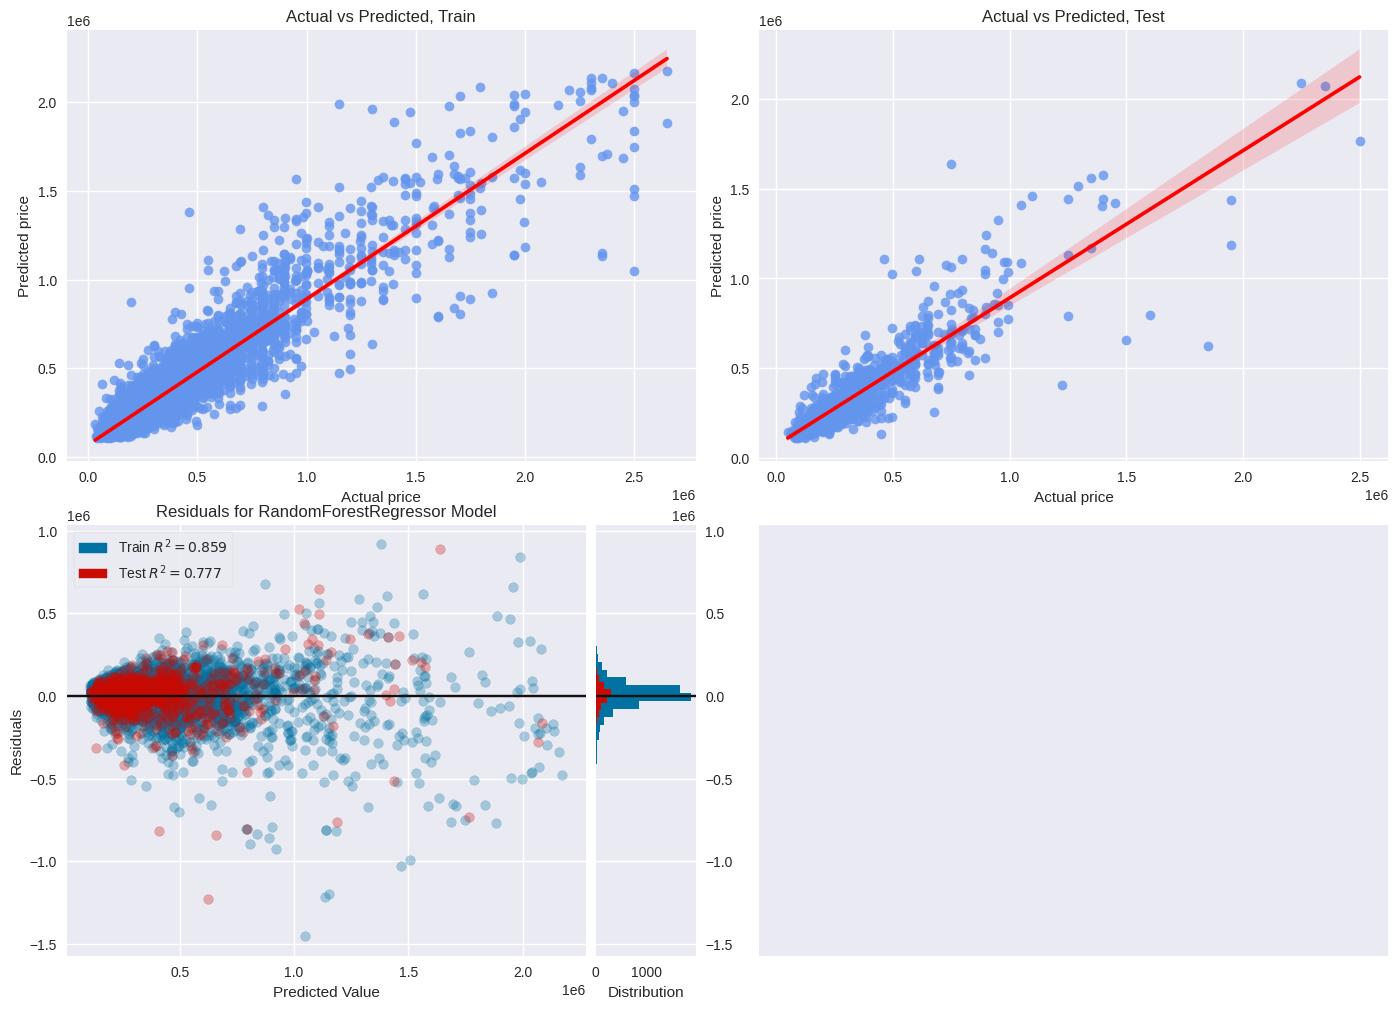

In [66]:
residuals(rfr, X_train, X_test, y_train, y_test)

**Conclusions**
- The tendency to understimate high values is a little smoother in the random forest.
- The performance of the model is better predicting houses prices cheapper than a million euros than highers as well. 
- The voting regressor is still better than the random forest.

### Metrics

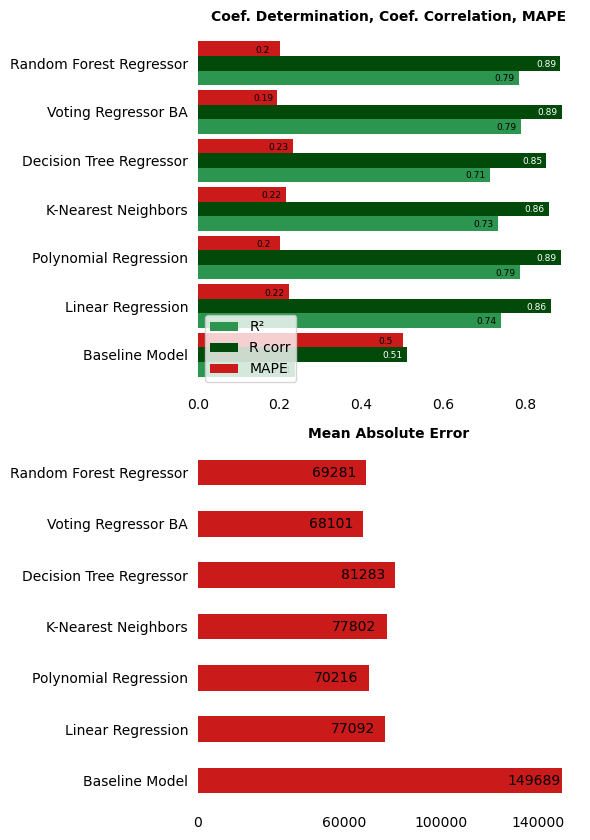

In [67]:
plot_metrics(metrics_to_plot)

In [68]:
comp_met(metrics_to_plot, 'Random Forest Regressor', 'Voting Regressor BA')

Improvement respect Baseline Model: 80409€ -> 54%
Improvement respect Last Best Model: -1180€ -> -2%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|80,409€|-1180€|
|54%|-2%|

## Extreme Gradient Boosting

The next code will give us the RMSE in the trainig set and in the test set 300 times, adding a new estimator every time. This will help us to choose the optimum number of estimators.

In [69]:
pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features,
                                           regressor=None)


df = data.copy()
y2 = df['price']
X2 = df.drop(columns='price')

X2 = pipe_estimator.fit_transform(X2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.15,
                                                        random_state=7)

xgb2 = XGBRegressor(n_estimators=300, 
                    max_depth=3,
                    learning_rate=.1,
                    subsample=.25)
   
xgb2.fit(X_train2, y_train2,
         eval_set=[(X_train2, y_train2), (X_test2, y_test2)],
        # early_stopping_rounds=50
        )

[0]	validation_0-rmse:453858.50000	validation_1-rmse:407035.78125
[1]	validation_0-rmse:417879.43750	validation_1-rmse:373322.31250
[2]	validation_0-rmse:385127.96875	validation_1-rmse:341416.40625
[3]	validation_0-rmse:355655.90625	validation_1-rmse:313810.03125
[4]	validation_0-rmse:330040.59375	validation_1-rmse:289391.84375
[5]	validation_0-rmse:306681.15625	validation_1-rmse:267665.34375
[6]	validation_0-rmse:286222.62500	validation_1-rmse:248507.42188
[7]	validation_0-rmse:268065.71875	validation_1-rmse:231538.64062
[8]	validation_0-rmse:251982.89062	validation_1-rmse:216865.62500
[9]	validation_0-rmse:238569.12500	validation_1-rmse:205224.12500
[10]	validation_0-rmse:226877.82812	validation_1-rmse:194323.71875
[11]	validation_0-rmse:216007.82812	validation_1-rmse:184942.50000
[12]	validation_0-rmse:207419.68750	validation_1-rmse:177339.81250
[13]	validation_0-rmse:198736.68750	validation_1-rmse:170030.28125
[14]	validation_0-rmse:191717.45312	validation_1-rmse:163892.39062
[15]	

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=300, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.25,
             tree_method='exact', validate_parameters=1, verbosity=None)

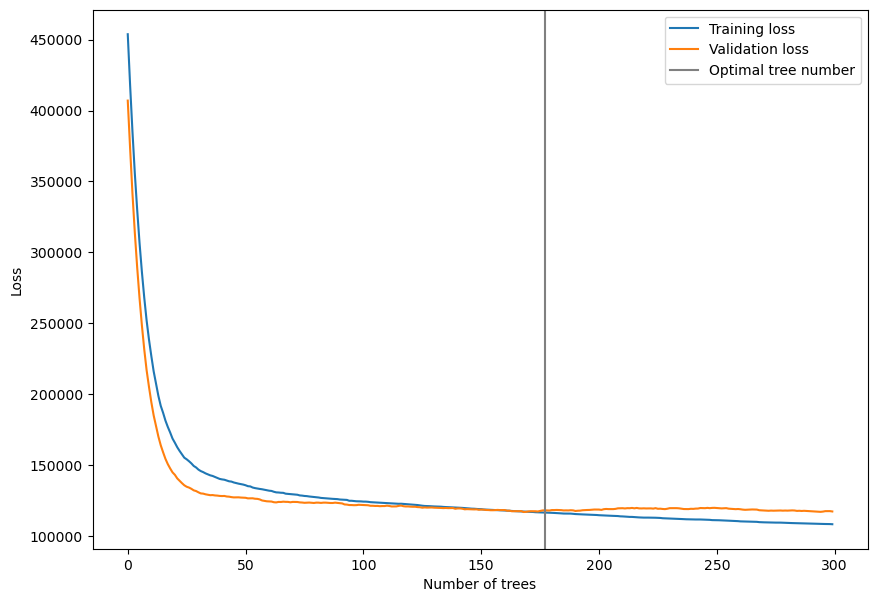

In [70]:
results = xgb2.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(177, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend();

Once we know the optimum number of estimators we can obtain the metrics of our model. After a few iterations I realised that a `max_depth` of 3 helps us reduce overfitting.

In [71]:
xgb_pipe_estimator = transformer_estimator(num_transformation='identity', 
                                           regressor=XGBRegressor(
                                               n_estimators=177,
                                               max_depth=3,
                                               learning_rate=.1,
                                               subsample=.25),
                                           levels_list=[levels_place, levels_type_house],
                                           poly_degree=1,
                                           num_feat=num_features,
                                           cat_feat=cat_features)

scores = scores_statistics(estimator=xgb_pipe_estimator, 
                           scoring_dict=scoring, 
                           X_train=X_train, 
                           y_train=np.log(y_train), 
                           cv=10, 
                           return_train_score=False)

r2 mean: 0.7994686204789524
r2 std: 0.013499178613303185 

MAE mean: -0.20017776724835143
MAE std: 0.0032564906850859206 

MAPE mean: -0.015886482553951843
MAPE std: 0.0002736263430325494 

RMSE mean: -0.27231217920462353
RMSE std: 0.00583530421225313 



### Overfitting Analysis

In [72]:
xgb = xgb_pipe_estimator.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(xgb.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(xgb.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['XGB'] = metrics

Performance on the training set:
 ----------
R²: 0.8331674196290405
MAE: 72882.37395240908
MAPE: 0.19372965397613542
RMSE: 124187.57583254504
R (corr): 0.9178748205365387

Performance on the test set:
 ----------
R²: 0.7994186081142483
MAE: 69398.07721755898
MAPE: 0.2016391510405155
RMSE: 114213.77902922733
R (corr): 0.8945629850017706



### Residuals Diagnostic

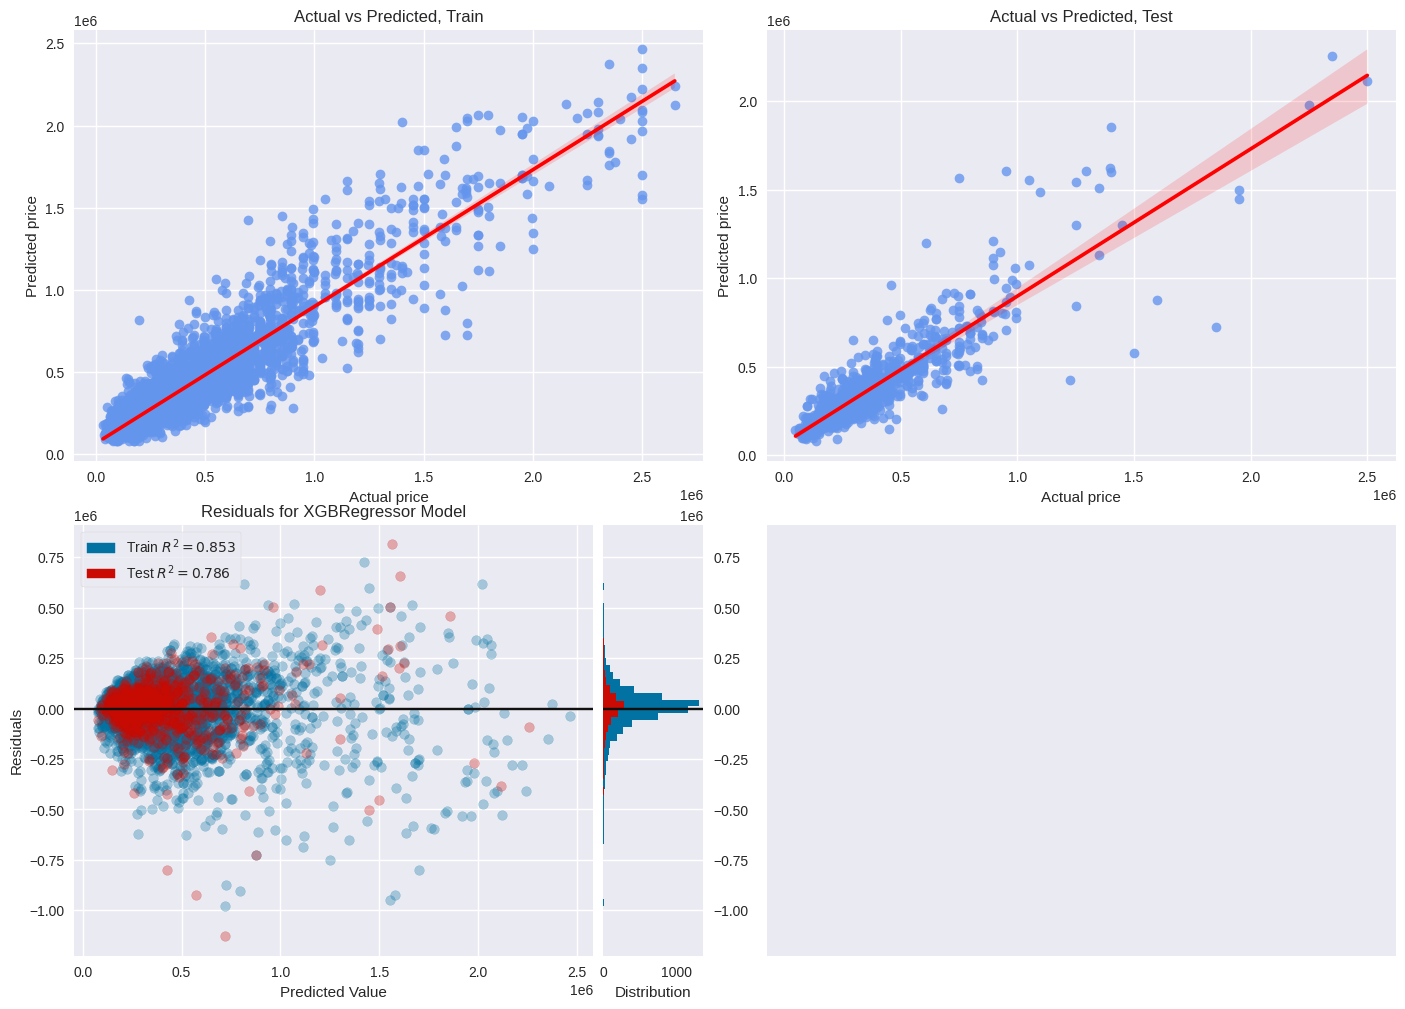

In [73]:
residuals(xgb_pipe_estimator, X_train, X_test, y_train, y_test)

**Conclusions**
- The XGBRegressor appears to be a little bit worse than the Random Forest.
- Following the same line as the previous models, the model's performance is better predicting house prices cheapper than a million euros than higher ones as well.
- The tendency to understimate high values is still there.

### Metrics

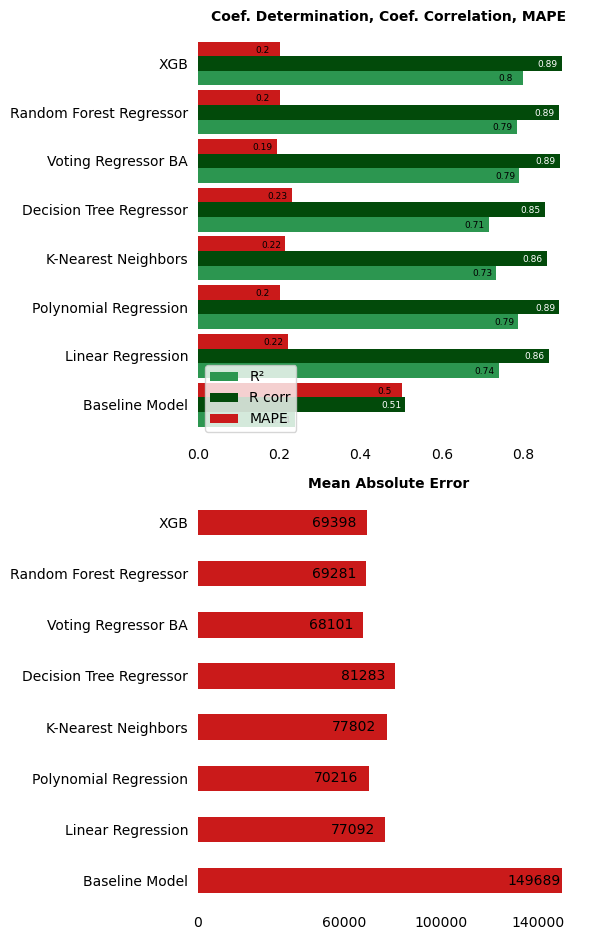

In [74]:
plot_metrics(metrics_to_plot)

In [75]:
comp_met(metrics_to_plot, 'XGB', 'Voting Regressor BA')

Improvement respect Baseline Model: 80291€ -> 54%
Improvement respect Last Best Model: -1297€ -> -2%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|80,291€|-1,297€|
|54%|-2%|

## Voting Regressor with Ensemble Methods

Now let's see some combinations of voting regressors to see their performance.

The voting regressor that is performing better is the second, made up of:
- Voting Regressor Basic Algorithms
- Random Forest
- Extreme Gradient Boosting

So we will focus on it before try all voting regressors.

### Voting Regressor 1: poly + rfr + xgb

In [76]:
scores_dict = {}
scores_dict['Polynomial Regression'] = metrics_to_plot['Polynomial Regression'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weigth_list = get_weights(scores_dict=scores_dict)

{'Polynomial Regression': 0.7877040579998882, 'Random Forest Regressor': 0.7851403274949148, 'XGB': 0.7994186081142483}


In [77]:
polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor1 = VotingRegressor(
    estimators= [('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor1}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=np.log(y_train), 
                            cv=5, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7928184790851968
MAE mean: -0.2038427354598086
----------
Random Forest Regressor
r2 mean: 0.7944466442615464
MAE mean: -0.20072440174222678
----------
XGBoost
r2 mean: 0.7993637083704411
MAE mean: -0.20113001642457698
----------
Voting Regressor
r2 mean: 0.8109657624920453
MAE mean: -0.19303144190561963
----------


In [78]:
voting_regressor1.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(voting_regressor1.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(voting_regressor1.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8482624086046617
MAE: 68040.05793902176
MAPE: 0.1815576689166261
RMSE: 118436.15758144583
R (corr): 0.9262570266752961

Performance on the test set:
 ----------
R²: 0.8070445975433637
MAE: 66429.78341979074
MAPE: 0.19288439725139817
RMSE: 112021.56931196326
R (corr): 0.8988295048579842



### Voting Regressor 2: voting_regressor_BA + rfr + xgb 

In [79]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weight_list = get_weights(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7904928639240477, 'Random Forest Regressor': 0.7851403274949148, 'XGB': 0.7994186081142483}


In [80]:
# voting_regressor_BA = voting_regressor_BA
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weight_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor2}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=np.log(y_train), 
                            cv=5, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7975002586096303
MAE mean: -0.20011488206715738
----------
Random Forest Regressor
r2 mean: 0.7944466442615463
MAE mean: -0.20072440174222678
----------
XGBoost
r2 mean: 0.7993637083704411
MAE mean: -0.20113001642457698
----------
Voting Regressor
r2 mean: 0.8083994547295994
MAE mean: -0.19400451496030105
----------


In [81]:
voting_regressor2.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(voting_regressor2.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(voting_regressor2.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Voting Regressor 2'] = metrics

Performance on the training set:
 ----------
R²: 0.8477218930779594
MAE: 66999.97403362712
MAPE: 0.17794443522542308
RMSE: 118646.91509146197
R (corr): 0.9272564567635737

Performance on the test set:
 ----------
R²: 0.8041115548787191
MAE: 66369.05996327414
MAPE: 0.19219627390138755
RMSE: 112869.75714140486
R (corr): 0.897430435145656



### Voting Regressor 3: rfr + xgb

In [82]:
scores_dict = {}
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]


models_weigth_list = get_weights(scores_dict=scores_dict)

{'Random Forest Regressor': 0.7851403274949148, 'XGB': 0.7994186081142483}


In [83]:
# polyr = poly_pipe_estimator
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor3 = VotingRegressor(
    estimators= [#('poly', polyr),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list,
)

models_dict = {#'Polynomial Regression': polyr, 
               'Random Forest Regressor': rfr, 
               'XGBoost': egb,
               'Voting Regressor': voting_regressor3}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=np.log(y_train), 
                            cv=6, 
                            return_train_score=False)

Random Forest Regressor
r2 mean: 0.7950178624583297
MAE mean: -0.20055132887851726
----------
XGBoost
r2 mean: 0.7987159114119763
MAE mean: -0.20071628299200703
----------
Voting Regressor
r2 mean: 0.8047719820255456
MAE mean: -0.19631594567274815
----------


In [84]:
voting_regressor3.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(voting_regressor3.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(voting_regressor3.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8493831050250172
MAE: 67625.1132231173
MAPE: 0.18091885039074526
RMSE: 117997.97688596773
R (corr): 0.9273539560406493

Performance on the test set:
 ----------
R²: 0.8015047943091511
MAE: 67518.04815255846
MAPE: 0.19615208958593772
RMSE: 113618.27513820132
R (corr): 0.8957584678133014



### Voting Regressor 4: voting_regressor_BA + rfr

In [85]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]

models_weigth_list = get_weights(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7904928639240477, 'Random Forest Regressor': 0.7851403274949148}


In [86]:
voting_regressor4 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr)], 
    weights= models_weigth_list,
)

models_dict = {'Voting Regressor BA': voting_regressor_BA, 
               'Random Forest Regressor': rfr,
               'Voting Regressor4': voting_regressor4}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=np.log(y_train), 
                            cv=5, 
                            return_train_score=False)

Voting Regressor BA
r2 mean: 0.7975002586096303
MAE mean: -0.20011488206715738
----------
Random Forest Regressor
r2 mean: 0.7944466442615463
MAE mean: -0.20072440174222678
----------
Voting Regressor4
r2 mean: 0.8047196460014607
MAE mean: -0.19538140011181326
----------


In [87]:
voting_regressor4.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(voting_regressor4.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(voting_regressor4.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                   y_pred=y_pred, 
                   squared=False)

Performance on the training set:
 ----------
R²: 0.8491799406350684
MAE: 65718.26021822463
MAPE: 0.1746878558177369
RMSE: 118077.53272948513
R (corr): 0.9277990334931855

Performance on the test set:
 ----------
R²: 0.7979274856858734
MAE: 66698.53847570512
MAPE: 0.19261891812595408
RMSE: 114637.52567357218
R (corr): 0.8939918510186272



### Residuals Diagnostic Voting Regressor 2: 

Let's get the diagnostic for the second voting regressor.

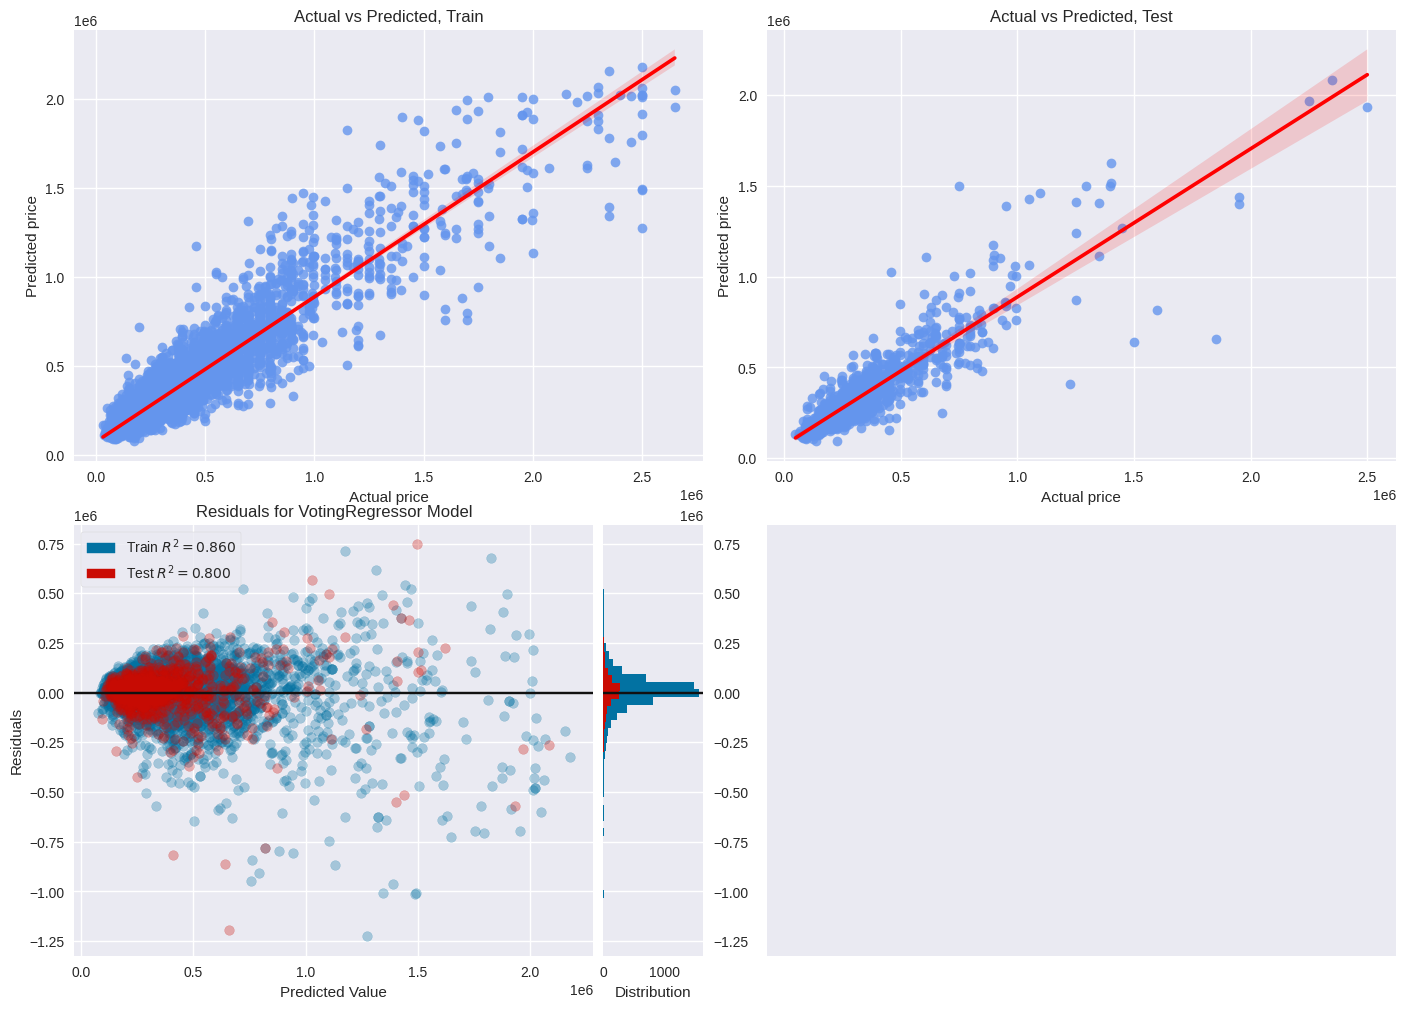

In [88]:
residuals(voting_regressor2, X_train, X_test, y_train, y_test)

**Conclusions**
- This is the best model as can be observed bellow.
- The model's performance is still better predicting houses prices cheapper than a million euros than higher ones. 
- There is still a light tendency to understimate values.

### Metrics

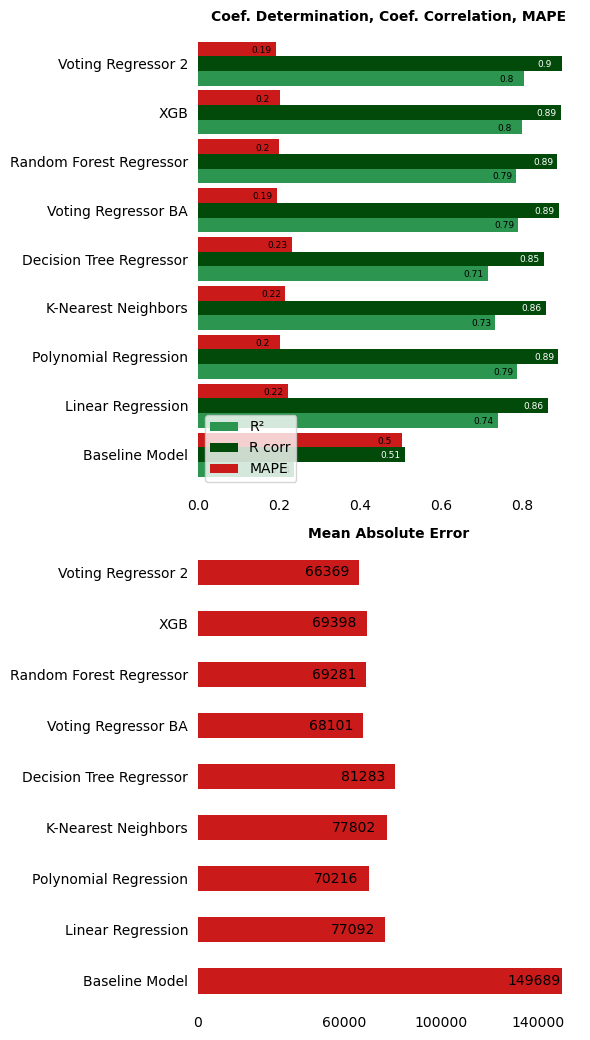

In [89]:
plot_metrics(metrics_to_plot)

In [90]:
comp_met(metrics_to_plot, 'Voting Regressor 2', 'Voting Regressor BA')

Improvement respect Baseline Model: 83320€ -> 56%
Improvement respect Last Best Model: 1732€ -> 3%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|83,320€|1,732€|
|56%|3%|

## Stacking

To finish let's train a Stacking model. It will be made up the Voting Regressor with Basic Algorithms and the Extreme Gradient Boosting.

- Regression Meta-Model: Linear Reagression

In [91]:
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
 #   level0.append(('voting_regressor_BA', voting_regressor_BA))
    level0.append(('poly', polyr))
    level0.append(('rfr', rfr))
    level0.append(('xgb', xgb_pipe_estimator))
    # define meta learner model
    level1 = LinearRegression()
    # define the stacking ensemble
    model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
    return model

In [92]:
models_dict = {
#    'Voting Regressor BA': voting_regressor_BA, 
    'Polynomial Regression': polyr,
    'Random Forest Regressor': rfr, 
    'XGBoost': xgb_pipe_estimator,
    'Stacking': get_stacking()}

for key in models_dict:
    print(key)  
    scores = compare_models(estimator=models_dict[key], 
                            scoring_dict=scoring_comp, 
                            X_train=X_train, 
                            y_train=np.log(y_train), 
                            cv=5, 
                            return_train_score=False)

Polynomial Regression
r2 mean: 0.7928184790851968
MAE mean: -0.2038427354598086
----------
Random Forest Regressor
r2 mean: 0.7944466442615463
MAE mean: -0.20072440174222678
----------
XGBoost
r2 mean: 0.7993637083704411
MAE mean: -0.20113001642457698
----------
Stacking
r2 mean: 0.81007552149477
MAE mean: -0.19419296686242915
----------


### Overfitting Analysis

In [93]:
stacking = get_stacking()
stacking.fit(X_train, np.log(y_train))

print('Performance on the training set:\n', '-'*10)
y_pred_train = np.exp(stacking.predict(X_train))
metrics_regression(y_test=y_train, 
                   y_pred=y_pred_train, 
                   squared=False)

print('Performance on the test set:\n', '-'*10)
y_pred = np.exp(stacking.predict(X_test))
metrics = metrics_regression(y_test=y_test, 
                             y_pred=y_pred, 
                             squared=False)

metrics_to_plot['Stacking Model'] = metrics

Performance on the training set:
 ----------
R²: 0.854169581866115
MAE: 67570.23541031331
MAPE: 0.18054287679902617
RMSE: 116107.90172429105
R (corr): 0.9266862798193379

Performance on the test set:
 ----------
R²: 0.8060951635674205
MAE: 66729.47111479213
MAPE: 0.19280158947790307
RMSE: 112296.83129322866
R (corr): 0.8987690807573716



### Residuals Diagnostic

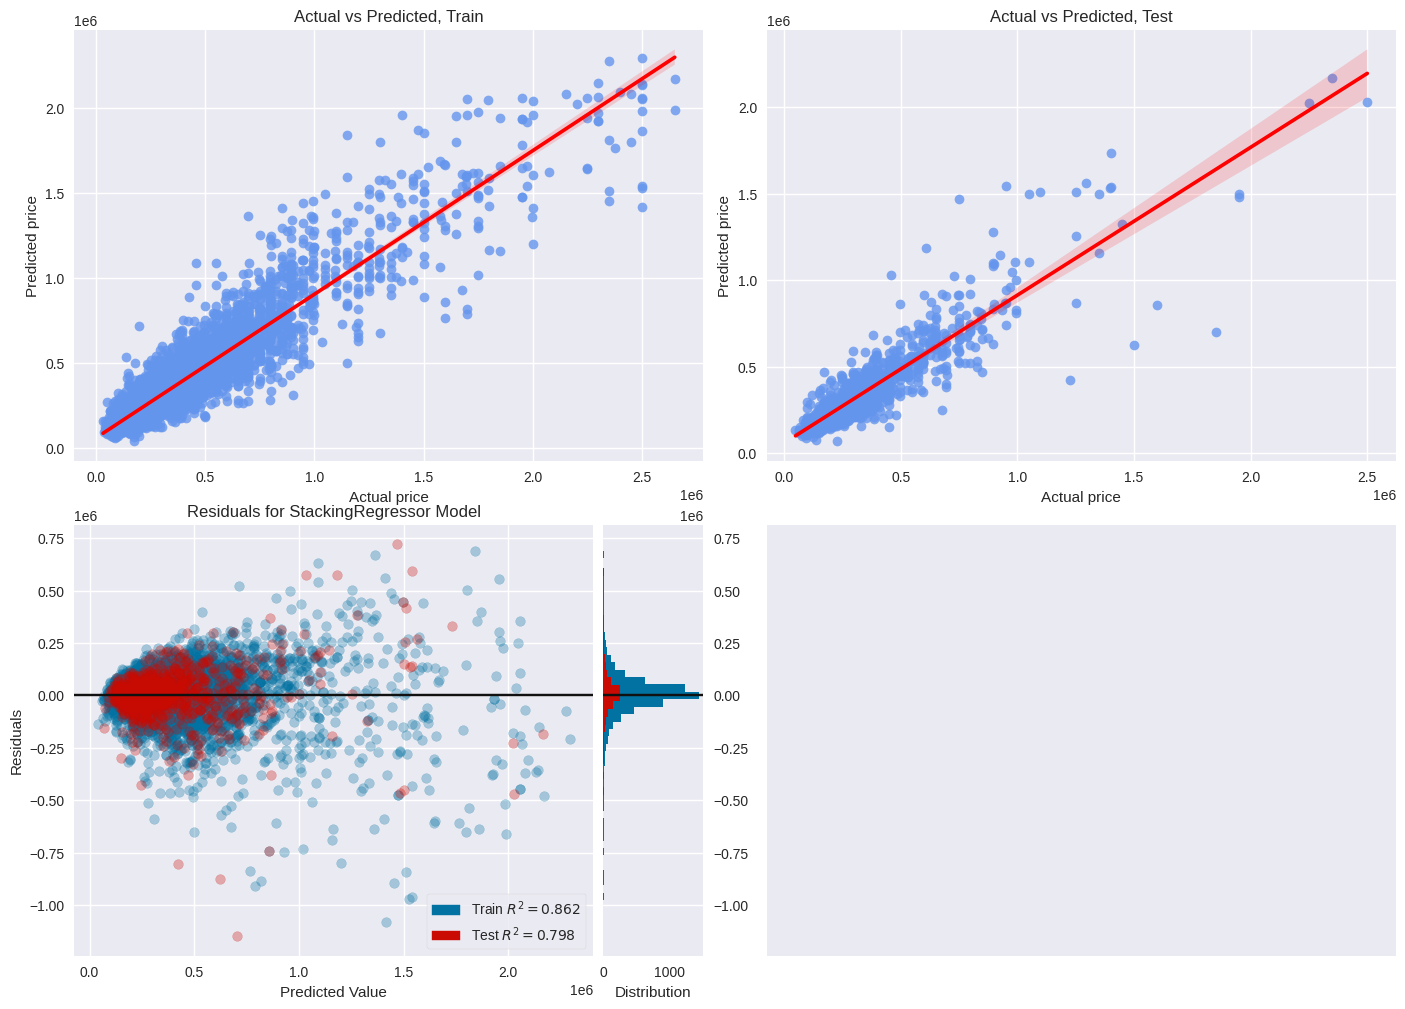

In [94]:
residuals(stacking, X_train, X_test, y_train, y_test)

**Conclusions**
- We have got some good performance in exchange of supporting more complexity.
- Following the same line as the previous models, the performance of the model is better predicting houses prices cheapper than a million euros than highers as well.
- The tendency to understimate high values is still there.

### Metrics

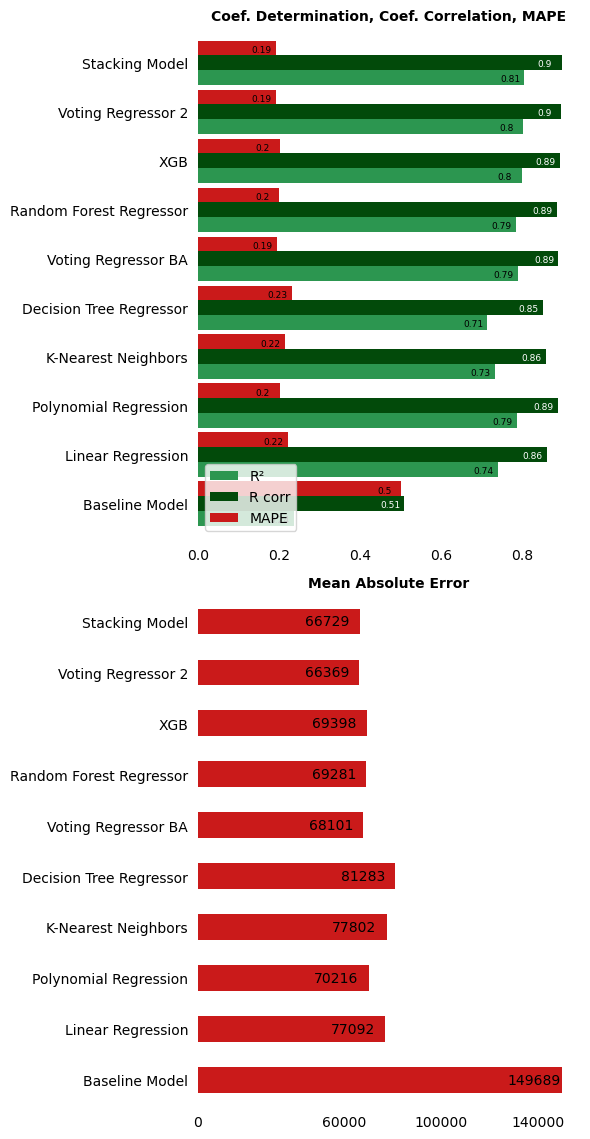

In [95]:
plot_metrics(metrics_to_plot)

In [96]:
comp_met(metrics_to_plot, 'Stacking Model', 'Voting Regressor 2')

Improvement respect Baseline Model: 82960€ -> 55%
Improvement respect Last Best Model: -360€ -> -1%


|Improvement respect Baseline Model (MAE)|Improvemenet respect Best Last Model (MAE)|
|:---:|:---:|
|82,960€|-360€|
|55%|-1%|

# Conclusions and Model Selection

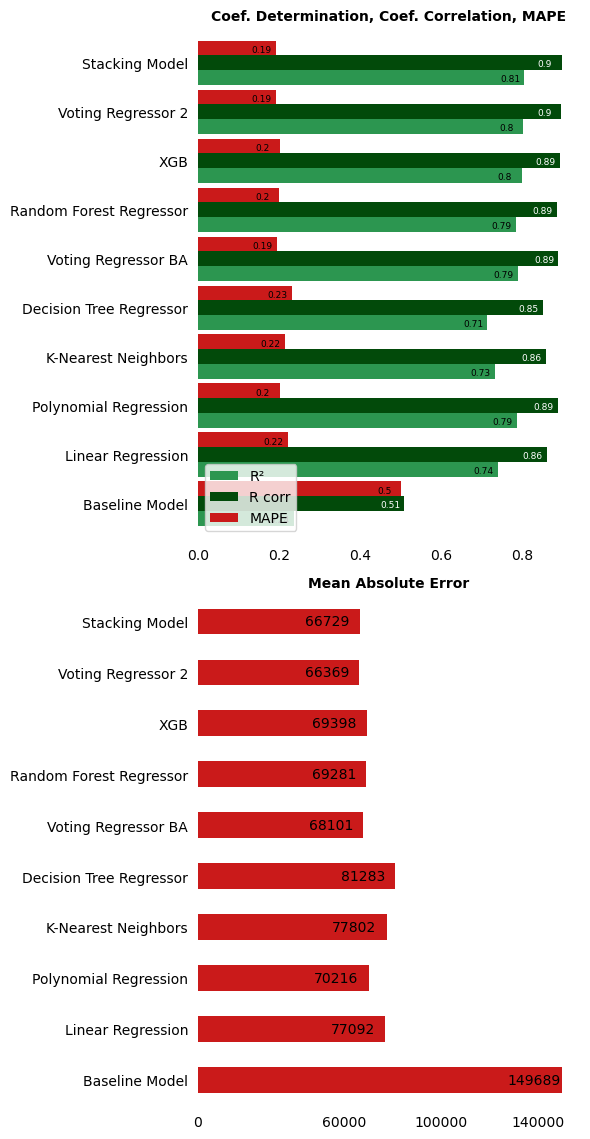

In [97]:
plot_metrics(metrics_to_plot=metrics_to_plot)

The following are the insights and conclusions that I have obtained throughout the notebook:

- The best models obtain *coefficient of determination* around 0.8 so those models are able to explain an 80% of the variability in prices. In *Mean Absolute Error* terms this is an error between 66,000€ and 70,000€ aproximately  in test set. This is not a super good score but it is not very bad as well taking into account the low number of features we are worked with. Also it is improving the *Baseline Model* by around 80,000€ so I am happy with that since the mean prices are so high in Ireland.

![](imgs/pp-23.png)

- As we were increasing the complexity of the models the performance went up but the improvement wasn't to high so we need to take a conciencious decision about what model we will use to predict the houses prices.

- Most of models tend to understimate houses prices which actual prices are over a million euros. Despite most houses are in the range price under a million this is still worrying. Our models are able to learn the relationship between preditor variables and the response variable better when the actual price of the house is under a million. That could be due to a lack of samples of expensive houses or due to a lack of predictors that can explain better the relationship with the price when it is too much high. Some predictors that perhaps explain that expensive prices could be the house year of construction, the average anual income of residents in areas with expensive prices, etc.  

- Another important aspect is the type of error that is less dangerous. Our model will be used to find potential investment opportunities which means that if the model understimates a house price, that house would be less interesting to us as investemnt opportunity, discouraging us to invest money in that operation. That means that we would not win money but we would not loss it either. However, if the model tends to overstimate the price of a house it would be encouraging us to invest in that house so we could buy an asset which actual value is lower than its actual price. That means that we could loss money. So we can conclude that a model that tends to understimate asset prices is less dangerous to us that one that tends to overstimate them.

- Some future steps to improve our capability to predict houses prices are the following:
    - Obtaining more information from the current variables we have. We could cluster the data or try to combine a few variables to get others with more predicting power. (Upgrade: Clustering the data to obtain a new feature has been already done but the results were not very good. It could be tried again when more variables were available).
    - Obtaining more information from the current variables we have and other information we don't have as demographic data, income level per capita and area or city, distance from houses to diferent points of interest (schools, museums, universities, public transport, etc), weather data, etc. 
    - Also we could try to develop different models for houses with prices under and over a million euros to figure out if it can perform better.  
    - Finally we could try deep learning techniques to figure out the performance.
    
   
By the moment I will use the *Voting Regressor 2* model as it was the best one.

# Fails

Bellow is showed the metrics obtained in different transformations and variables when the results were worst than with the current ones. They have been showed here for comparing purposes.

**Metrics with Clusters Variable**

A clusters variable was tried to see its effects on the models. This was tried without logaritmic transformation in the target.

They are a little bit better with some algorithms and a little bit worse with others. As the best model is the Voting Regressor 2 and it perfoms worse with the cluster column I decided to drop that column. 

![](imgs/mae_w_clusters.png)

**Metrics Dropping Missing Values**

If the missing values are dropped at the beginning of the notebook it would reduce the number of samples from 7344 to 5778. The resulting MAE would be significantly worse.

![](imgs/mae_dropna.png)

**Metrics with Most Frequent Imputation**

If we used the `most_frequent` transformation instead the current one we would obtain a little worse performance.

![](imgs/mae_most_frequent.png)

**Metrics without Logarithmic Transformation**

If we don't use the `logarithmic` transformation to the `price` column the results are a little bit worse in all models. The difference is really significant for the Linaer Regression Model.

![](imgs/mae_no_log.png)

# Save Voting Regressor 2 Model

Before saving the winner model we will fit it to all the data instead only the training set. 

In [98]:
# Split data in predictors and target
X, y = split_data(data=data, 
                  target='price', 
                  test_size=.15, 
                  output='X_y',
                  random_state=7)

X: (7344, 7)
y: (7344,)


The model will predict values similar to the logarithmics of the price values so we must remember to apply an antilogarithmic transformation to the results.

**Voting Regressor 2 = Voting Regressor BA + Random Forest Regressor + XGBoost**

In [99]:
scores_dict = {}
scores_dict['Voting Regressor BA'] = metrics_to_plot['Voting Regressor BA'][0]
scores_dict['Random Forest Regressor'] = metrics_to_plot['Random Forest Regressor'][0]
scores_dict['XGB'] = metrics_to_plot['XGB'][0]

models_weigth_list = get_weights(scores_dict=scores_dict)

{'Voting Regressor BA': 0.7904928639240477, 'Random Forest Regressor': 0.7851403274949148, 'XGB': 0.7994186081142483}


In [100]:
# voting_regressor_BA = voting_regressor_BA
# rfr = rfr
egb = xgb_pipe_estimator

voting_regressor2 = VotingRegressor(
    estimators= [('voting_reg', voting_regressor_BA),
                 ('rf', rfr),
                 ('egb', egb)], #('rfr',rfr)
    weights= models_weigth_list)

voting_regressor2.fit(X, y)

VotingRegressor(estimators=[('voting_reg',
                             VotingRegressor(estimators=[('poly',
                                                          Pipeline(steps=[('preprocessor',
                                                                           ColumnTransformer(remainder='passthrough',
                                                                                             transformers=[('num',
                                                                                                            Pipeline(steps=[('power_transformer',
                                                                                                                             PowerTransformer()),
                                                                                                                            ('poly',
                                                                                                                             PolynomialFeature

In [101]:
joblib.dump(voting_regressor2, 'models/houses_prices_vr2_model.plk')

['models/houses_prices_vr2_model.plk']

In [102]:
model = joblib.load('models/houses_prices_vr2_model.plk')
# model

# Prepare Data for Plotly Dash 

Now we have a trained model that we can use to predict prices. Here we will be using the data the model was trained with since is the data we have, but the model is useful to predict current unseen data from the real market. 

In [103]:
y_pred = model.predict(X)
# We convert y_pred to a list to avoid a problem with nan values
data['predicted_price'] = list(y_pred) 
# The residual is what will tell us whether the asset is a potential opportunity
data['residual'] = data.predicted_price - data.price
data['res_percentage'] = data.residual / data.price

As we are calculating the residuals extracting the  actual price from the predicted one, if the residual is a positive number it means that the predicted price is higher than the actual one so the asset could be an investment opportunity. 

We can see different examples of how the final DataFrame is by running the cell below.

In [104]:
data.sample()

,price,floor_area,latitude,longitude,bedroom,bathroom,type_house,place,predicted_price,residual,res_percentage
2703,120000.0,66,53.366291,-8.192159,2,1,NaN,Ballinasloe,193177.464415,73177.464415,0.609812


In [105]:
data.to_csv('data/data_predicted.csv', sep=',', index=False)